In [ ]:
%%shell
jupyter nbconvert Assignment_3_Language_Modeling_with_RNN.ipynb

[NbConvertApp] Converting notebook Assignment_3_Language_Modeling_with_RNN.ipynb to html
[NbConvertApp] Writing 1720900 bytes to Assignment_3_Language_Modeling_with_RNN.html


<img src="https://github.com/djp840/MSDS_458_Public/blob/master/images/NorthwesternHeader.png?raw=1">

#### Vivian Xia
## MSDS458 Research Assignment 3: Analyze AG News Data

## Import packages 

In [ ]:
import datetime
from packaging import version
from collections import Counter
import numpy as np
import pandas as pd
import time

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds

In [ ]:
%matplotlib inline
np.set_printoptions(precision=3, suppress=True)

### Verify TensorFlow Version and Keras Version

In [ ]:
print("This notebook requires TensorFlow 2.0 or above")
print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >=2

This notebook requires TensorFlow 2.0 or above
TensorFlow version:  2.8.0


In [ ]:
print("Keras version: ", keras.__version__)

Keras version:  2.8.0


### Functions For Research Assignment 

In [ ]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

In [ ]:
def plot_confusion_matrix(conf_mx):
    fig, ax = plt.subplots(figsize=(8,8))
    sns.heatmap(conf_mx, annot=True, fmt='.2f', cbar=False, ax=ax, cmap=plt.cm.gray)
    plt.ylabel('true label')
    plt.xlabel('predicted label')

###  TensorFlow Datasets Information<br>
<div class="alert alert-block alert-info">
    <b> ag_news_subset</b><br>
    See https://www.tensorflow.org/datasets/catalog/ag_news_subset
    </div>

Get all the words in the documents (as well as the number of words in each document) by using the encoder to get the indices associated with each token and then translating the indices to tokens. But first we need to get the "unpadded" new articles so that we can get their length.

In [ ]:
#register ag_news_subset so that tfds.load doesn't generate a checksum (mismatch) error
!python -m tensorflow_datasets.scripts.download_and_prepare --register_checksums --datasets=ag_news_subset

# https://www.tensorflow.org/datasets/splits
# The full `train` and `test` splits, interleaved together.
ri = tfds.core.ReadInstruction('train') + tfds.core.ReadInstruction('test')
dataset_all, info = tfds.load('ag_news_subset', with_info=True,  split=ri, as_supervised=True)

I0220 00:25:08.068357 139734943283072 download_and_prepare.py:200] Running download_and_prepare for dataset(s):
ag_news_subset
I0220 00:25:08.327215 139734943283072 dataset_info.py:434] Load pre-computed DatasetInfo (eg: splits, num examples,...) from GCS: ag_news_subset/1.0.0
I0220 00:25:08.703137 139734943283072 dataset_info.py:361] Load dataset info from /tmp/tmpoc1t4jh4tfds
I0220 00:25:08.707423 139734943283072 download_and_prepare.py:138] download_and_prepare for dataset ag_news_subset/1.0.0...
I0220 00:25:08.707926 139734943283072 dataset_builder.py:357] Generating dataset ag_news_subset (/root/tensorflow_datasets/ag_news_subset/1.0.0)
Dl Completed...: 0 url [00:00, ? url/s]
Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]I0220 00:25:09.054957 139734943283072 download_manager.py:476] Downloading https://drive.google.com/uc?export=download&id=0Bz8a_Dbh9QhbUDNpeUdjb0wxRms into /root/tensorflow_datasets/downloads/ucexport_download_id_0Bz8a_Dbh9Qh

##  Exploratory Analysis AG News Subset

Get information about the ag_news_subset dataset. The training and test data are combined for a total of 127,600 news articles.

In [ ]:
print(info)

tfds.core.DatasetInfo(
    name='ag_news_subset',
    version=1.0.0,
    description='AG is a collection of more than 1 million news articles.
News articles have been gathered from more than 2000  news sources by ComeToMyHead in more than 1 year of activity.
ComeToMyHead is an academic news search engine which has been running since July, 2004.
The dataset is provided by the academic comunity for research purposes in data mining (clustering, classification, etc),
information retrieval (ranking, search, etc), xml, data compression, data streaming,
and any other non-commercial activity.
For more information, please refer to the link http://www.di.unipi.it/~gulli/AG_corpus_of_news_articles.html .

The AG's news topic classification dataset is constructed by Xiang Zhang (xiang.zhang@nyu.edu) from the dataset above.
It is used as a text classification benchmark in the following paper:
Xiang Zhang, Junbo Zhao, Yann LeCun. Character-level Convolutional Networks for Text Classification. Advanc

In [ ]:
tfds.as_dataframe(dataset_all.take(10),info)

,description,label
0,"AMD #39;s new dual-core Opteron chip is designed mainly for corporate computing applications, including databases, Web services, and financial transactions.",3 (Sci/Tech)
1,Reuters - Major League Baseball\Monday announced a decision on the appeal filed by Chicago Cubs\pitcher Kerry Wood regarding a suspension stemming from an\incident earlier this season.,1 (Sports)
2,"President Bush #39;s quot;revenue-neutral quot; tax reform needs losers to balance its winners, and people claiming the federal deduction for state and local taxes may be in administration planners #39; sights, news reports say.",2 (Business)
3,"Britain will run out of leading scientists unless science education is improved, says Professor Colin Pillinger.",3 (Sci/Tech)
4,"London, England (Sports Network) - England midfielder Steven Gerrard injured his groin late in Thursday #39;s training session, but is hopeful he will be ready for Saturday #39;s World Cup qualifier against Austria.",1 (Sports)
5,TOKYO - Sony Corp. is banking on the \$3 billion deal to acquire Hollywood studio Metro-Goldwyn-Mayer Inc...,0 (World)
6,"Giant pandas may well prefer bamboo to laptops, but wireless technology is helping researchers in China in their efforts to protect the engandered animals living in the remote Wolong Nature Reserve.",3 (Sci/Tech)
7,"VILNIUS, Lithuania - Lithuania #39;s main parties formed an alliance to try to keep a Russian-born tycoon and his populist promises out of the government in Sunday #39;s second round of parliamentary elections in this Baltic country.",0 (World)
8,Witnesses in the trial of a US soldier charged with abusing prisoners at Abu Ghraib have told the court that the CIA sometimes directed abuse and orders were received from military command to toughen interrogations.,0 (World)
9,"Dan Olsen of Ponte Vedra Beach, Fla., shot a 7-under 65 Thursday to take a one-shot lead after two rounds of the PGA Tour qualifying tournament.",1 (Sports)


### Review Labels (Categories) 

In [ ]:
print(f'There are {info.features["label"].num_classes} classes in the dataset.')
print(f'The class names are {info.features["label"].names}')

There are 4 classes in the dataset.
The class names are ['World', 'Sports', 'Business', 'Sci/Tech']


In [ ]:
# classes dictionary
categories = dict(enumerate(info.features["label"].names))
categories

{0: 'World', 1: 'Sports', 2: 'Business', 3: 'Sci/Tech'}

The 127,600 news articles are evenly distributed among the 4 categories

In [ ]:
train_categories = [categories[label] for label in dataset_all.map(lambda text, label: label).as_numpy_iterator()]
Counter(train_categories).most_common()

[('Sci/Tech', 31900), ('Sports', 31900), ('Business', 31900), ('World', 31900)]

### Experiment A.1 - Vocabulary Size: All 


Use the tf.keras.layers.experimental.preprocessing.TextVectorization layer to transform each news article into a "list" of non-negative integers representing the tokens in the news article.

For the purpose of training our models, each such "encoding" will have a fixed length corresponding to the news article(s) with the most tokens. Shorter articles will be right-padded with zeros in the encoding. Also to speed up the training process, we will set max_tokens = 1000 so that words not in the vabulary set of top 1000 most common tokes are encoded as 1. But first we set max_tokens = None (which is the default value) in order to get the vocabulary size of the corpus.


In [ ]:
%%time
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(max_tokens=None)
encoder.adapt(dataset_all.map(lambda text, label: text)) 
vocab = np.array(encoder.get_vocabulary())

Cause: could not parse the source code of <function <lambda> at 0x7fb899d73440>: no matching AST found among candidates:

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function <lambda> at 0x7fb899d73440>: no matching AST found among candidates:

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function <lambda> at 0x7fb899d73440>: no matching AST found among candidates:

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
CPU times: user 2min 36s, sys: 23.4 s, total: 2min 59s
Wall time: 2min 13s


In [ ]:
print(f"There are {len(vocab)} vocabulary words in the corpus.")

There are 95976 vocabulary words in the corpus.


There are 95976 vocabulary words in the corpus.

The .adapt method sets the layer's vocabulary. Here are the first 20 tokens. After the padding and unknown tokens they're sorted by frequency:

In [ ]:
vocab[:20]

array(['', '[UNK]', 'the', 'a', 'to', 'of', 'in', 'and', 'on', 'for',
       'that', '39s', 'with', 'its', 'as', 'at', 'is', 'said', 'by', 'it'],
      dtype='<U150')

Let us get the total number of words in the corpus and the sizes of the news articles

In [ ]:
%%time
doc_sizes = []
corpus = []
for example, _ in dataset_all.as_numpy_iterator():
  enc_example = encoder(example)
  doc_sizes.append(len(enc_example))
  corpus+=list(enc_example.numpy())

CPU times: user 10min 4s, sys: 12.9 s, total: 10min 17s
Wall time: 9min 41s


In [ ]:
print(f"There are {len(corpus)} words in the corpus of {len(doc_sizes)} news articles.")
print(f"Each news article has between {min(doc_sizes)} and {max(doc_sizes)} tokens in it.")

There are 3909695 words in the corpus of 127600 news articles.
Each news article has between 3 and 173 tokens in it.


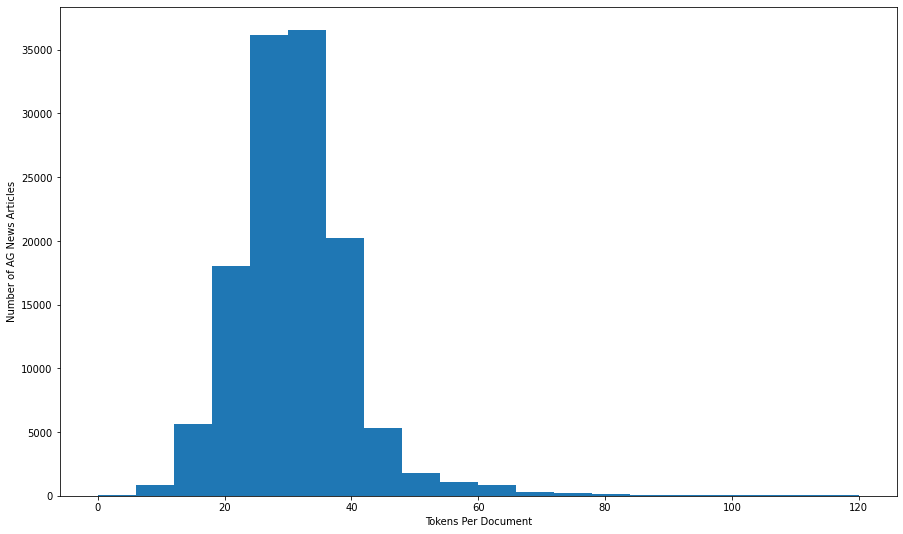

In [ ]:
plt.figure(figsize=(15,9))
plt.hist(doc_sizes, bins=20,range = (0,120))
plt.xlabel("Tokens Per Document")
plt.ylabel("Number of AG News Articles");

### Experiment A.2 - Vocabulary Size: 1000 


Encode the news articles using the top 1000 most common words in the corpus

In [ ]:
%%time
encoder_1000 = tf.keras.layers.experimental.preprocessing.TextVectorization(max_tokens=1000)
encoder_1000.adapt(dataset_all.map(lambda text, label: text))
vocab_1000 = np.array(encoder_1000.get_vocabulary());

Cause: could not parse the source code of <function <lambda> at 0x7fb89a4507a0>: no matching AST found among candidates:

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function <lambda> at 0x7fb89a4507a0>: no matching AST found among candidates:

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function <lambda> at 0x7fb89a4507a0>: no matching AST found among candidates:

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
CPU times: user 2min 27s, sys: 21.5 s, total: 2min 49s
Wall time: 2min 22s


The .adapt method sets the layer's vocabulary. Here are the first 20 tokens. After the padding and unknown tokens they're sorted by frequency:

In [ ]:
vocab_1000[:20]

array(['', '[UNK]', 'the', 'a', 'to', 'of', 'in', 'and', 'on', 'for',
       'that', '39s', 'with', 'its', 'as', 'at', 'is', 'said', 'by', 'it'],
      dtype='<U14')

Once the vocabulary is set, the layer can encode text into indices. The tensors of indices are 0-padded to the longest sequence in the batch (unless you set a fixed `output_sequence_length`)

In particular, 0 is use for padding, 1 for the unknown words, 2 for the common word.

With the default settings, the process is not completely reversible. There are three main reasons for that:

1. The default value for `preprocessing.TextVectorization`'s `standardize` argument is `"lower_and_strip_punctuation"`.
2. The limited vocabulary size and lack of character-based fallback results in some unknown tokens.

In [ ]:
for example, label in dataset_all.take(3):
  print('text: ', example.numpy())
  print('class: ', categories[label.numpy()])
  encoder_1000_example = encoder_1000(example).numpy()
  print('encoded example: \n',encoder_1000_example)
  print("Round-trip: ", " ".join(vocab[encoder_1000_example]))
  print('\n')

text:  b'AMD #39;s new dual-core Opteron chip is designed mainly for corporate computing applications, including databases, Web services, and financial transactions.'
class:  Sci/Tech
encoded example: 
 [  1  11  21   1   1 694  16 733   1   9 687   1 959 244   1 233 219   7
 315   1]
Round-trip:  [UNK] 39s new [UNK] [UNK] chip is designed [UNK] for corporate [UNK] applications including [UNK] web services and financial [UNK]


text:  b'Reuters - Major League Baseball\\Monday announced a decision on the appeal filed by Chicago Cubs\\pitcher Kerry Wood regarding a suspension stemming from an\\incident earlier this season.'
class:  Sports
encoded example: 
 [ 28 159 139   1  97   3 461   8   2   1 714  18 357   1 650   1   1   3
   1   1  23   1 574  40 101]
Round-trip:  reuters major league [UNK] announced a decision on the [UNK] filed by chicago [UNK] kerry [UNK] [UNK] a [UNK] [UNK] from [UNK] earlier this season


text:  b'President Bush #39;s  quot;revenue-neutral quot; tax reform ne

Determine the number of non-vocabulary words in each news articles (denoted by 1s in the encoding)

In [ ]:
%%time
doc1000_sizes = []
corpus1000 = []
count1000 = 0
useless = 0
# stop = 0
percents = []
for example, _ in dataset_all.as_numpy_iterator():
  # stop+=1
  # if stop > 5: break
  enc_example = encoder_1000(example)
  num_ones = tf.math.count_nonzero(enc_example==1).numpy()
  percent_ones = round(num_ones*100/len(enc_example))
  # print(f"{percent_ones}%")
  percents.append(percent_ones)

  s = set(list(enc_example.numpy()))
  if s == {1}: useless+=1

  doc1000_sizes.append(len(enc_example))
  corpus1000+=list(enc_example.numpy())

  count1000 += tf.math.count_nonzero(enc_example>1)

CPU times: user 11min 34s, sys: 14.5 s, total: 11min 49s
Wall time: 11min 12s


In [ ]:
Counter(percents).most_common(10)
np.unique(percents, return_counts=True) 

(array([  0,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,
         15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
         28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,
         41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,
         54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,
         67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,
         80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,
         93,  95,  97, 100]),
 array([  12,    5,   20,   29,   49,   71,  120,  137,  172,  274,  486,
         368,  682,  777,  828, 1346, 1376, 2123, 1610, 2863, 2687, 3018,
        3957, 3315, 4605, 3934, 4148, 5737, 4954, 5072, 6123, 6165, 3255,
        5095, 4596, 3438, 5880, 4205, 3109, 4063, 3555, 3030, 2904, 2294,
        1967, 1716, 2174,  368, 2486,  234, 1246,  747,  573,  547,  520,
         441,  348,  217,  250,  135,  234,   49,  131,  101,   11,  135,
          40,  

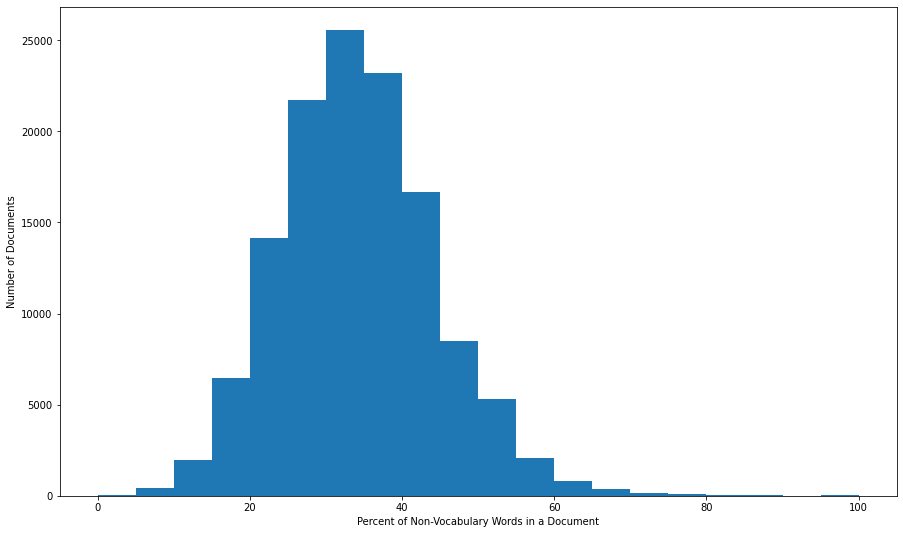

In [ ]:
plt.figure(figsize=(15,9))
plt.hist(percents, 20)
plt.ylabel('Number of Documents')
plt.xlabel('Percent of Non-Vocabulary Words in a Document');

In [ ]:
print(f"There are {count1000} top {len(vocab_1000)} vocabulary words in the corpus.")

There are 2602670 top 1000 vocabulary words in the corpus.


### Experiment A.3 - Vocabulary Size: 500


Encode the news articles using the top 500 most common words in the corpus

In [ ]:
%%time
encoder_500 = tf.keras.layers.experimental.preprocessing.TextVectorization(max_tokens=500)
encoder_500.adapt(dataset_all.map(lambda text, label: text))
vocab_500 = np.array(encoder_500.get_vocabulary());

Cause: could not parse the source code of <function <lambda> at 0x7fb899d73440>: no matching AST found among candidates:

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function <lambda> at 0x7fb899d73440>: no matching AST found among candidates:

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function <lambda> at 0x7fb899d73440>: no matching AST found among candidates:

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
CPU times: user 2min 30s, sys: 21.1 s, total: 2min 51s
Wall time: 2min 22s


In [ ]:
for example, label in dataset_all.take(3):
  print('text: ', example.numpy())
  print('class: ', categories[label.numpy()])
  encoder_500_example = encoder_500(example).numpy()
  print('encoded example: \n',encoder_500_example)
  print("Round-trip: ", " ".join(vocab[encoder_500_example]))
  print('\n')

text:  b'AMD #39;s new dual-core Opteron chip is designed mainly for corporate computing applications, including databases, Web services, and financial transactions.'
class:  Sci/Tech
encoded example: 
 [  1  11  21   1   1   1  16   1   1   9   1   1   1 244   1 233 219   7
 315   1]
Round-trip:  [UNK] 39s new [UNK] [UNK] [UNK] is [UNK] [UNK] for [UNK] [UNK] [UNK] including [UNK] web services and financial [UNK]


text:  b'Reuters - Major League Baseball\\Monday announced a decision on the appeal filed by Chicago Cubs\\pitcher Kerry Wood regarding a suspension stemming from an\\incident earlier this season.'
class:  Sports
encoded example: 
 [ 28 159 139   1  97   3 461   8   2   1   1  18 357   1   1   1   1   3
   1   1  23   1   1  40 101]
Round-trip:  reuters major league [UNK] announced a decision on the [UNK] [UNK] by chicago [UNK] [UNK] [UNK] [UNK] a [UNK] [UNK] from [UNK] [UNK] this season


text:  b'President Bush #39;s  quot;revenue-neutral quot; tax reform needs losers to b

Determine the number of non-vocabulary words in each news articles (denoted by 1s in the encoding)

In [ ]:
%%time
doc500_sizes = []
corpus500 = []
count500 = 0
useless = 0
# stop = 0
percents = []
for example, _ in dataset_all.as_numpy_iterator():
  # stop+=1
  # if stop > 5: break
  enc_example = encoder_500(example)
  num_ones = tf.math.count_nonzero(enc_example==1).numpy()
  percent_ones = round(num_ones*100/len(enc_example))
  # print(f"{percent_ones}%")
  percents.append(percent_ones)

  s = set(list(enc_example.numpy()))
  if s == {1}: useless+=1

  doc500_sizes.append(len(enc_example))
  corpus500+=list(enc_example.numpy())

  count500 += tf.math.count_nonzero(enc_example>1)

CPU times: user 9min 54s, sys: 9.75 s, total: 10min 4s
Wall time: 9min 40s


In [ ]:
Counter(percents).most_common(10)
np.unique(percents, return_counts=True) 

(array([  5,   7,   8,   9,  10,  11,  12,  13,  14,  15,  16,  17,  18,
         19,  20,  21,  22,  23,  24,  25,  26,  27,  28,  29,  30,  31,
         32,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42,  43,  44,
         45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,  56,  57,
         58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,
         71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,
         84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,
         97, 100]),
 array([   1,    2,    9,    8,    8,   10,   21,   14,   42,   46,   59,
          98,  120,  204,  174,  365,  384,  495,  744,  733, 1150, 1142,
        1371, 2210, 2209, 2553, 3492, 3940, 2593, 3943, 4288, 3427, 6516,
        5252, 4123, 6147, 5897, 5304, 5635, 5049, 4641, 4398, 5752, 1546,
        6892, 1077, 4240, 2508, 2207, 2133, 2070, 1674, 1529, 1237,  910,
         707, 1041,  314,  502,  439,   87,  451,  180,  174,  132,  200,
          64,   97,   47,

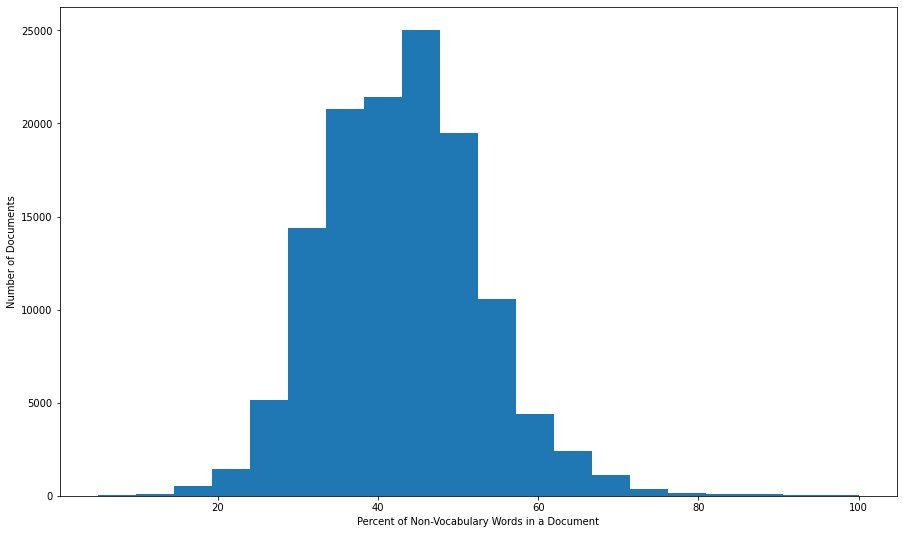

In [ ]:
plt.figure(figsize=(15,9))
plt.hist(percents, 20)
plt.ylabel('Number of Documents')
plt.xlabel('Percent of Non-Vocabulary Words in a Document');

In [ ]:
print(f"There are {count500} top {len(vocab_500)} vocabulary words in the corpus.")

There are 2245833 top 500 vocabulary words in the corpus.


### Experiment A.4 - Output Sequence Length: 40 & Vocabulary Size: 1000


Set the output_sequence_length to 40 to truncate any sequence length longer than 40 tokens to 40 and pad the shorter sequnces up to 40 tokens. Encode the news articles using the top 1000 most common words in the corpus.

In [ ]:
%%time
encoder_a4 = tf.keras.layers.experimental.preprocessing.TextVectorization(max_tokens=1000, output_sequence_length=40)
encoder_a4.adapt(dataset_all.map(lambda text, label: text))
vocab_a4 = np.array(encoder_a4.get_vocabulary());

Cause: could not parse the source code of <function <lambda> at 0x7fb88b921440>: no matching AST found among candidates:

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function <lambda> at 0x7fb88b921440>: no matching AST found among candidates:

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function <lambda> at 0x7fb88b921440>: no matching AST found among candidates:

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
CPU times: user 2min 39s, sys: 21.2 s, total: 3min
Wall time: 2min 17s


Once the vocabulary is set, the layer can encode text into indices. The tensors of indices are 0-padded or truncated to 50 tokens.

In [ ]:
for example, label in dataset_all.take(3):
  print('text: ', example.numpy())
  print('class: ', categories[label.numpy()])
  encoder_a4_example = encoder_a4(example).numpy()
  print('encoded example: \n',encoder_a4_example)
  print("Round-trip: ", " ".join(vocab[encoder_a4_example]))
  print('\n')

text:  b'AMD #39;s new dual-core Opteron chip is designed mainly for corporate computing applications, including databases, Web services, and financial transactions.'
class:  Sci/Tech
encoded example: 
 [  1  11  21   1   1 694  16 733   1   9 687   1 959 244   1 233 219   7
 315   1   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0]
Round-trip:  [UNK] 39s new [UNK] [UNK] chip is designed [UNK] for corporate [UNK] applications including [UNK] web services and financial [UNK]                    


text:  b'Reuters - Major League Baseball\\Monday announced a decision on the appeal filed by Chicago Cubs\\pitcher Kerry Wood regarding a suspension stemming from an\\incident earlier this season.'
class:  Sports
encoded example: 
 [ 28 159 139   1  97   3 461   8   2   1 714  18 357   1 650   1   1   3
   1   1  23   1 574  40 101   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0]
Round-trip:  reuters major league [UNK] announced a decision on the [UN

Determine the number of non-vocabulary words in each news articles (denoted by 1s in the encoding)

In [ ]:
%%time
doc_a4_sizes = []
corpus_a4 = []
count_a4 = 0
useless = 0
# stop = 0
percents = []
for example, _ in dataset_all.as_numpy_iterator():
  # stop+=1
  # if stop > 5: break
  enc_example = encoder_a4(example)
  num_ones = tf.math.count_nonzero(enc_example==1).numpy()
  percent_ones = round(num_ones*100/len(enc_example))
  # print(f"{percent_ones}%")
  percents.append(percent_ones)

  s = set(list(enc_example.numpy()))
  if s == {1}: useless+=1

  doc_a4_sizes.append(len(enc_example))
  corpus_a4+=list(enc_example.numpy())

  count_a4 += tf.math.count_nonzero(enc_example>1)

CPU times: user 13min 51s, sys: 16.1 s, total: 14min 7s
Wall time: 13min 31s


In [ ]:
Counter(percents).most_common(10)
np.unique(percents, return_counts=True) 

(array([ 0,  2,  5,  8, 10, 12, 15, 18, 20, 22, 25, 28, 30, 32, 35, 38, 40,
        42, 45, 48, 50, 52, 55, 58, 60, 62, 65, 68, 70, 72, 75, 78, 80, 82,
        85, 88, 90]),
 array([   12,   111,   605,  1548,  3462,  6047,  9136, 11951, 14090,
        14715, 14247, 13052, 10792,  8605,  6372,  4540,  3254,  2054,
         1269,   706,   451,   244,   144,    64,    44,    28,     7,
           10,    11,     3,     6,     1,     4,     5,     7,     2,
            1]))

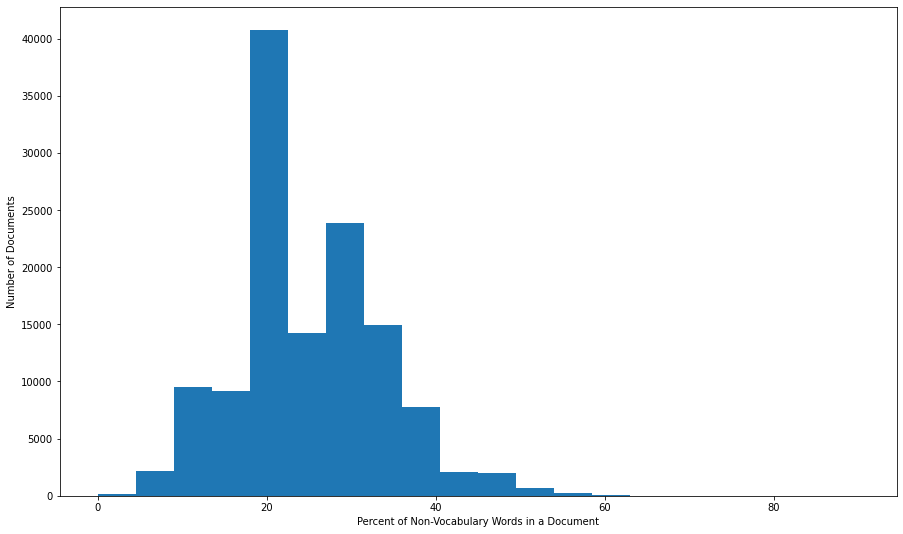

In [ ]:
plt.figure(figsize=(15,9))
plt.hist(percents, 20)
plt.ylabel('Number of Documents')
plt.xlabel('Percent of Non-Vocabulary Words in a Document');

In [ ]:
print(f"There are {count_a4} top {len(vocab_a4)} vocabulary words in the corpus.")

There are 2526611 top 1000 vocabulary words in the corpus.


## Preprocessing Data Create Input Pipeline

In [ ]:
# register  ag_news_subset so that tfds.load doesn't generate a checksum (mismatch) error
!python -m tensorflow_datasets.scripts.download_and_prepare --register_checksums --datasets=ag_news_subset

dataset, info = tfds.load('ag_news_subset', with_info=True,  split=['train[:114000]','train[114000:]', 'test[:]'], as_supervised=True)
train_dataset, validation_dataset, test_dataset = dataset

I0220 00:26:13.967495 139734423324544 download_and_prepare.py:200] Running download_and_prepare for dataset(s):
ag_news_subset
I0220 00:26:13.968349 139734423324544 dataset_info.py:361] Load dataset info from /root/tensorflow_datasets/ag_news_subset/1.0.0
I0220 00:26:13.969425 139734423324544 download_and_prepare.py:138] download_and_prepare for dataset ag_news_subset/1.0.0...
I0220 00:26:13.969650 139734423324544 dataset_builder.py:299] Reusing dataset ag_news_subset (/root/tensorflow_datasets/ag_news_subset/1.0.0)
name: "ag_news_subset"
description: "AG is a collection of more than 1 million news articles.\nNews articles have been gathered from more than 2000  news sources by ComeToMyHead in more than 1 year of activity.\nComeToMyHead is an academic news search engine which has been running since July, 2004.\nThe dataset is provided by the academic comunity for research purposes in data mining (clustering, classification, etc),\ninformation retrieval (ranking, search, etc), xml, data

In [ ]:
len(train_dataset),len(validation_dataset),len(test_dataset) 

(114000, 6000, 7600)

### Review Distribution of Categorical Labels for the 114000 training data (news articles)

In [ ]:
from collections import Counter
train_categories = [categories[label] for label in train_dataset.map(lambda text, label: label).as_numpy_iterator()]
Counter(train_categories).most_common()

[('Business', 28531), ('Sports', 28495), ('World', 28491), ('Sci/Tech', 28483)]

Review Example with Interger Label (text, label pairs):

In [ ]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('class: ', categories[label.numpy()])

text:  b'AMD #39;s new dual-core Opteron chip is designed mainly for corporate computing applications, including databases, Web services, and financial transactions.'
class:  Sci/Tech


### Preprocessing Shuffle Data for Training and Create Batches of `(text, label)` pairs:

In [ ]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [ ]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
validation_dataset = validation_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

Example data from training set with a numeric label

In [ ]:
for example, label in train_dataset.take(2):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b'Longtime Business Week editor-in-chief Stephen Shepard is expected to be named the first dean of the City University #39;s planned Graduate School of Journalism.'
 b"Reuters - The United States rejected North Korea's\\conditions for a resumption of six-party talks on scrapping its\\nuclear programs, a response to Pyongyang's latest demands that\\left the two nations in a stalemate."
 b'A World Food Programme survey says almost half of all families in Darfur are hungry, confirming aid agency fears.']

labels:  [2 0 0]
texts:  [b'Six suspected Islamic militants go on trial in Paris for an alleged plot to bomb the US embassy in 2001.'
 b'Peace Rules has been retired after a slight injury to the colt #39;s left front leg was discovered during training for Saturday #39;s \\$1 million Jockey Club Gold Cup at Belmont Park.'
 b"South Africa's wage dispute ends after unions representing public sector workers accept a revised government offer."]

labels:  [0 1 2]


Example data from training set with a text label

In [ ]:
for example, label in train_dataset.take(2):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', [categories[n] for n in label.numpy()[:3]])
  print()

texts:  [b'VA. TECH 16, UM 10: With an ACC title and BCS berth on the line, Miami stumbles. By BOB HARIG, Times Staff Writer. MIAMI - Perhaps they were too stunned to react.'
 b' CHICAGO (Reuters) - The dollar retreated on Thursday  following a report showing the U.S. trade deficit grew to the  second-highest level on record in August, stoking doubts about  U.S. economic growth.'
 b'TBILISI : Armed men abducted eight Georgian civilians in Georgia #39;s breakaway region of South Ossetia, an area that last month saw fighting between Tbilisi and Ossetian forces, police said.']

labels:  ['Sports', 'Business', 'Sci/Tech']

texts:  [b'Online search-engine leader Google is targeting the computer hard drive with software that promises to scour the clutter of documents, e-mails, instant messages and other stored files.'
 b'Reuters - Clothing maker and retailer Liz\\Claiborne Inc. on Thursday posted a 14 percent increase in\\third-quarter earnings, helped by its acquisition of ENYCE and\\solid 

## Create the Text Encoder

The raw text loaded by `tfds` needs to be processed before it can be used in a model. The simplest way to process text for training is using the `experimental.preprocessing.TextVectorization` layer. This layer has many capabilities, but this tutorial sticks to the default behavior.

Create the layer, and pass the dataset's text to the layer's `.adapt` method:
The processing of each sample contains the following steps:

    standardize each sample (usually lowercasing + punctuation stripping)
    split each sample into substrings (usually words)
    recombine substrings into tokens (usually ngrams)
    index tokens (associate a unique int value with each token)
    transform each sample using this index, either into a vector of ints or a dense float vector.


In [ ]:
VOCAB_SIZE=1000
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [ ]:
vocab = np.array(encoder.get_vocabulary())
len(vocab)

1000

Here are the first 20 tokens. After the padding and unknown tokens they're sorted by frequency: 

In [ ]:
vocab[:20]

array(['', '[UNK]', 'the', 'a', 'to', 'of', 'in', 'and', 'on', 'for',
       'that', '39s', 'with', 'its', 'as', 'at', 'is', 'said', 'by', 'it'],
      dtype='<U14')

Here are the 20 least frequent words.

In [ ]:
vocab[-20:]

array(['black', 'turn', 'build', 'countrys', 'advanced', 'whose',
       'crisis', 'create', '23', 'sources', 'body', 'militant', 'hope',
       'event', 'started', 'ready', 'jones', 'lawsuit', 'focus',
       'singapore'], dtype='<U14')

Once the vocabulary is set, the layer can encode text into indices. The tensors of indices are 0-padded to the longest sequence in the batch (unless you set a fixed `output_sequence_length`)

In [ ]:
example[:3]

<tf.Tensor: shape=(3,), dtype=string, numpy=
array([b'Online search-engine leader Google is targeting the computer hard drive with software that promises to scour the clutter of documents, e-mails, instant messages and other stored files.',
       b'Reuters - Clothing maker and retailer Liz\\Claiborne Inc. on Thursday posted a 14 percent increase in\\third-quarter earnings, helped by its acquisition of ENYCE and\\solid sales of brands such as Juicy Couture.',
       b'President Vicente Fox vowed to clean up Mexico #39;s police on Tuesday after violence that has shocked the country, and he told the capital #39;s left-wing mayor, his main political rival, to do the same.'],
      dtype=object)>

In [ ]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[164,   1, 215, 286,  16,   1,   2, 145, 941, 926,  12,  90,  10,
          1,   4,   1,   2,   1,   5,   1,   1,   1,   1,   7, 123,   1,
          1,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0],
       [ 28,   1, 173,   7, 729,   1,  49,   8,  45, 541,   3, 632,  88,
        531,   1, 281, 595,  18,  13,   1,   5,   1,   1, 138,   5,   1,
        396,  14,   1,   1,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,

With the default settings, the process is not completely reversible. There are three main reasons for that:

1. The default value for `preprocessing.TextVectorization`'s `standardize` argument is `"lower_and_strip_punctuation"`.
2. The limited vocabulary size and lack of character-based fallback results in some unknown tokens.

In [ ]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b'Online search-engine leader Google is targeting the computer hard drive with software that promises to scour the clutter of documents, e-mails, instant messages and other stored files.'
Round-trip:  online [UNK] leader google is [UNK] the computer hard drive with software that [UNK] to [UNK] the [UNK] of [UNK] [UNK] [UNK] [UNK] and other [UNK] [UNK]                                                                                                            

Original:  b'Reuters - Clothing maker and retailer Liz\\Claiborne Inc. on Thursday posted a 14 percent increase in\\third-quarter earnings, helped by its acquisition of ENYCE and\\solid sales of brands such as Juicy Couture.'
Round-trip:  reuters [UNK] maker and retailer [UNK] inc on thursday posted a 14 percent increase [UNK] earnings helped by its [UNK] of [UNK] [UNK] sales of [UNK] such as [UNK] [UNK]                                                                                                         

Original:  b

## Experiment B.1: Single Layer SimpleRNN

### Create the model

In [ ]:
num_classes = 4
model = tf.keras.Sequential([encoder
                            ,tf.keras.layers.Embedding(input_dim=len(encoder.get_vocabulary())
                            ,output_dim=64
                            # Use masking to handle the variable sequence lengths
                            ,mask_zero=True)
                            ,tf.keras.layers.SimpleRNN(64)
                            ,tf.keras.layers.Dense(64, activation='relu')
                            ,tf.keras.layers.Dense(num_classes, activation='softmax')
])

<div class="alert alert-block alert-success"> 
Please note that we choose to Keras sequential model here since all the layers in the model only have single input and produce single output. </div>

<div class="alert alert-block alert-info"> 
<b>tf.keras.Model</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/Model
</div>  

### Model Architecture Summary

In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (TextV  (None, None)             0         
 ectorization)                                                   
                                                                 
 embedding_4 (Embedding)     (None, None, 64)          64000     
                                                                 
 simple_rnn (SimpleRNN)      (None, 64)                8256      
                                                                 
 dense_7 (Dense)             (None, 64)                4160      
                                                                 
 dense_8 (Dense)             (None, 4)                 260       
                                                                 
Total params: 76,676
Trainable params: 76,676
Non-trainable params: 0
__________________________________________________

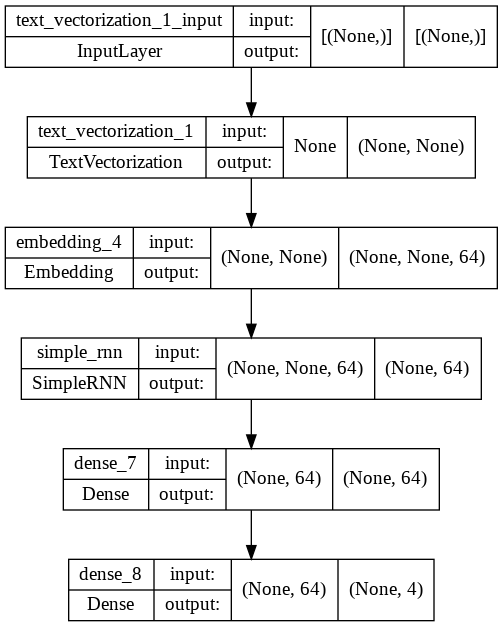

In [ ]:
keras.utils.plot_model(model, "SingleLayerSimpleRNN.png", show_shapes=True)

### Compile Model 

<div class="alert alert-block alert-info">
<b>tf.keras.losses.SparseCategoricalCrossentropy</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy</div>

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4)
              ,loss=tf.keras.losses.SparseCategoricalCrossentropy()
              ,metrics=['accuracy'])

The embedding layer [uses masking](../../guide/keras/masking_and_padding) to handle the varying sequence-lengths. All the layers after the `Embedding` support masking:

In [ ]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


### Train the model

<div class="alert alert-block alert-success">
    <b>Module: tf.keras.callbacks</b></div>

<div class="alert alert-block alert-info">
<b>tf.keras.callbacks.EarlyStopping</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping</div>

<div class="alert alert-block alert-info">
<b>tf.keras.callbacks.ModelCheckpoint</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint</div>

In [ ]:
start = time.time()
history = model.fit(train_dataset
                    ,epochs = 150
                    ,validation_data=validation_dataset
                    ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)]
                    )
print("Total time: ", time.time() - start, "seconds")

Epoch 1/150
1782/1782 [==============================] - 224s 123ms/step - loss: 0.8248 - accuracy: 0.6660 - val_loss: 0.5801 - val_accuracy: 0.7973
Epoch 2/150
1782/1782 [==============================] - 199s 112ms/step - loss: 0.5279 - accuracy: 0.8154 - val_loss: 0.5173 - val_accuracy: 0.8182
Epoch 3/150
1782/1782 [==============================] - 192s 108ms/step - loss: 0.4872 - accuracy: 0.8307 - val_loss: 0.4488 - val_accuracy: 0.8483
Epoch 4/150
1782/1782 [==============================] - 191s 107ms/step - loss: 0.4310 - accuracy: 0.8485 - val_loss: 0.4257 - val_accuracy: 0.8483
Epoch 5/150
1782/1782 [==============================] - 191s 107ms/step - loss: 0.4090 - accuracy: 0.8545 - val_loss: 0.4110 - val_accuracy: 0.8538
Epoch 6/150
1782/1782 [==============================] - 189s 106ms/step - loss: 0.4000 - accuracy: 0.8573 - val_loss: 0.4145 - val_accuracy: 0.8525
Epoch 7/150
1782/1782 [==============================] - 192s 108ms/step - loss: 0.3926 - accuracy: 0.8602

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

119/119 [==============================] - 2s 14ms/step - loss: 0.4285 - accuracy: 0.8455
Test Loss: 0.4284810721874237
Test Accuracy: 0.8455263376235962


### Plotting Performance Metrics

Use Matplotlib to create 2 plots--displaying the training and validation loss (resp. accuracy) for each (training) epoch side by side.

In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
losses = history.history['loss']
accs = history.history['accuracy']
val_losses = history.history['val_loss']
val_accs = history.history['val_accuracy']
epochs = len(losses)

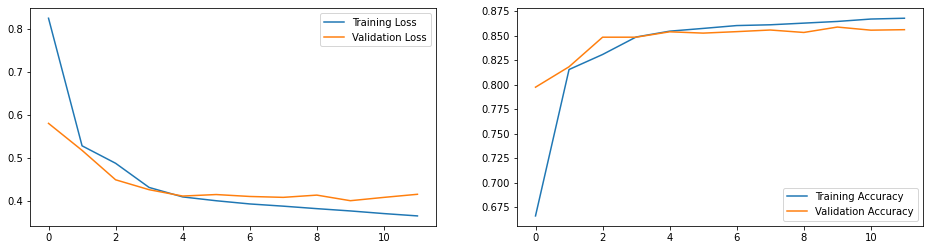

In [ ]:
plt.figure(figsize=(16, 4))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

### Confusion Matrix

In [ ]:
pred1 = model.predict(test_dataset)
pred1 = np.argmax(pred1, axis=1)

test_labels = np.concatenate([label for example, label in test_dataset], axis=0)
test_labels

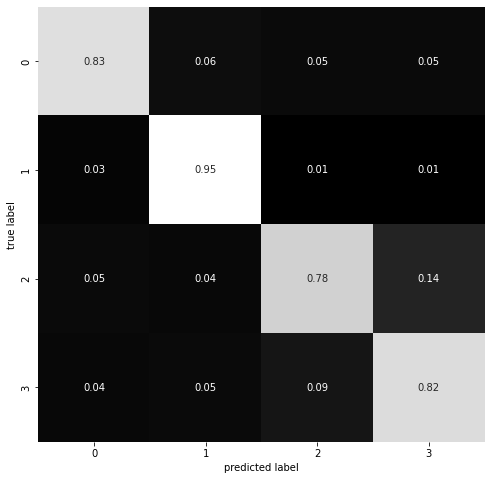

In [ ]:
conf_mx = confusion_matrix(test_labels, pred1)
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = np.round((conf_mx / row_sums), 2)

plot_confusion_matrix(norm_conf_mx)

### Visualize predictions

In [ ]:
preds = model.predict(test_dataset)
preds.shape

(7600, 4)

In [ ]:
cm = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)
df = pd.DataFrame(preds[0:15]
                  ,columns = ['World','Sports','Business','Sci/Tech']).T
df.style.format("{:.2%}").background_gradient(cmap=cm)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
World,0.14%,99.91%,0.07%,1.02%,99.28%,0.65%,0.58%,15.17%,92.16%,7.47%,99.82%,0.84%,0.46%,84.06%,99.14%
Sports,99.84%,0.00%,0.00%,98.89%,0.02%,0.19%,99.20%,82.58%,0.43%,0.07%,0.00%,0.73%,0.01%,1.12%,0.01%
Business,0.01%,0.06%,1.86%,0.03%,0.16%,11.51%,0.03%,0.10%,0.80%,75.92%,0.08%,1.83%,99.34%,3.32%,0.29%
Sci/Tech,0.01%,0.02%,98.07%,0.06%,0.53%,87.64%,0.19%,2.14%,6.61%,16.54%,0.09%,96.60%,0.19%,11.50%,0.57%


## Experiment B.2: Single Layer Bidirectional Simple RNN

### Create the model

<div class="alert alert-block alert-info">
    <b>tf.keras.layers.Bidirectional</b><br>
    https://www.tensorflow.org/api_docs/python/tf/keras/layers/Bidirectional
    </div>

<img src="https://github.com/djp840/MSDS_458_Public/blob/master/images/BidirectionalRNN.png?raw=1">

In [ ]:
num_classes = 4
model = tf.keras.Sequential([encoder
                            ,tf.keras.layers.Embedding(input_dim=len(encoder.get_vocabulary())
                            ,output_dim=64
                            # Use masking to handle the variable sequence lengths
                            ,mask_zero=True)
                            ,tf.keras.layers.Bidirectional(tf.keras.layers.SimpleRNN(64))
                            ,tf.keras.layers.Dense(64, activation='relu')
                            ,tf.keras.layers.Dense(num_classes, activation='softmax')
])

<div class="alert alert-block alert-success"> 
Please note that we choose to Keras sequential model here since all the layers in the model only have single input and produce single output. </div>

<div class="alert alert-block alert-info"> 
<b>tf.keras.Model</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/Model
</div>  

### Model Architecture Summary

In [ ]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (TextV  (None, None)             0         
 ectorization)                                                   
                                                                 
 embedding_5 (Embedding)     (None, None, 64)          64000     
                                                                 
 bidirectional (Bidirectiona  (None, 128)              16512     
 l)                                                              
                                                                 
 dense_9 (Dense)             (None, 64)                8256      
                                                                 
 dense_10 (Dense)            (None, 4)                 260       
                                                                 
Total params: 89,028
Trainable params: 89,028
Non-trai

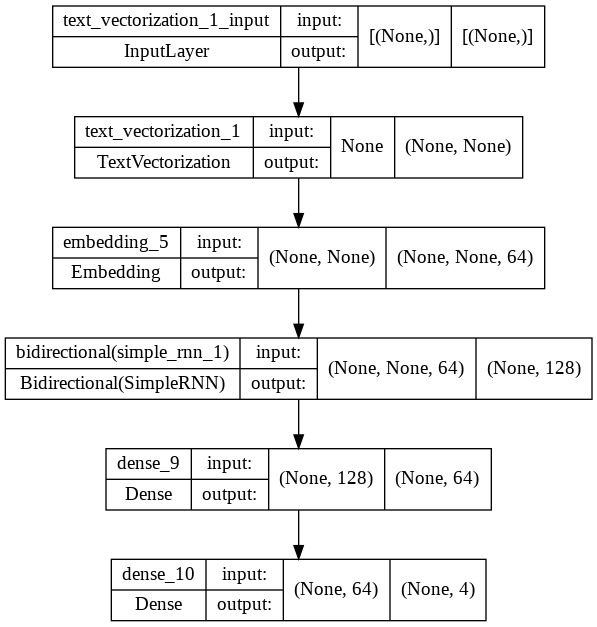

In [ ]:
keras.utils.plot_model(model, "SingleLayerBidirectionalSimpleRNN.png", show_shapes=True)

### Compile Model 

<div class="alert alert-block alert-info">
<b>tf.keras.losses.SparseCategoricalCrossentropy</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy</div>

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4)
              ,loss=tf.keras.losses.SparseCategoricalCrossentropy()
              ,metrics=['accuracy'])

The embedding layer [uses masking](../../guide/keras/masking_and_padding) to handle the varying sequence-lengths. All the layers after the `Embedding` support masking:

In [ ]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


### Train the model

<div class="alert alert-block alert-success">
    <b>Module: tf.keras.callbacks</b></div>

<div class="alert alert-block alert-info">
<b>tf.keras.callbacks.EarlyStopping</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping</div>

<div class="alert alert-block alert-info">
<b>tf.keras.callbacks.ModelCheckpoint</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint</div>

In [ ]:
start = time.time()
history = model.fit(train_dataset
                    ,epochs = 150
                    ,validation_data=validation_dataset
                    ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)]
                    )
print("Total time: ", time.time() - start, "seconds")

Epoch 1/150
1782/1782 [==============================] - 379s 211ms/step - loss: 0.6914 - accuracy: 0.7259 - val_loss: 0.4880 - val_accuracy: 0.8298
Epoch 2/150
1782/1782 [==============================] - 371s 208ms/step - loss: 0.4574 - accuracy: 0.8359 - val_loss: 0.4455 - val_accuracy: 0.8445
Epoch 3/150
1782/1782 [==============================] - 369s 207ms/step - loss: 0.4177 - accuracy: 0.8505 - val_loss: 0.4194 - val_accuracy: 0.8520
Epoch 4/150
1782/1782 [==============================] - 376s 211ms/step - loss: 0.3979 - accuracy: 0.8565 - val_loss: 0.4068 - val_accuracy: 0.8553
Epoch 5/150
1782/1782 [==============================] - 373s 209ms/step - loss: 0.3872 - accuracy: 0.8601 - val_loss: 0.4070 - val_accuracy: 0.8527
Epoch 6/150
1782/1782 [==============================] - 377s 212ms/step - loss: 0.3762 - accuracy: 0.8633 - val_loss: 0.3941 - val_accuracy: 0.8563
Epoch 7/150
1782/1782 [==============================] - 377s 211ms/step - loss: 0.3665 - accuracy: 0.8666

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

119/119 [==============================] - 3s 21ms/step - loss: 0.4064 - accuracy: 0.8553
Test Loss: 0.40636399388313293
Test Accuracy: 0.8552631735801697


### Plotting Performance Metrics

Use Matplotlib to create 2 plots--displaying the training and validation loss (resp. accuracy) for each (training) epoch side by side.

In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
losses = history.history['loss']
accs = history.history['accuracy']
val_losses = history.history['val_loss']
val_accs = history.history['val_accuracy']
epochs = len(losses)

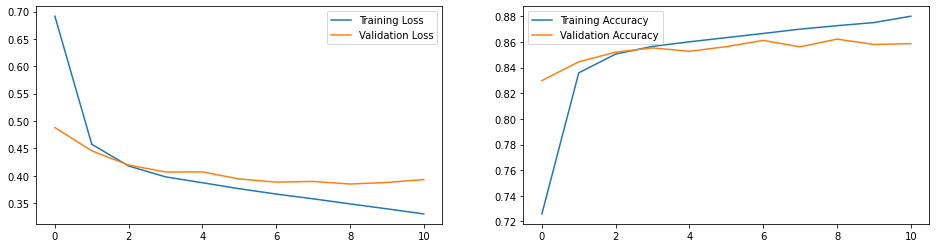

In [ ]:
plt.figure(figsize=(16, 4))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

### Confusion Matrix

In [ ]:
pred1 = model.predict(test_dataset)
pred1 = np.argmax(pred1, axis=1)

test_labels = np.concatenate([label for example, label in test_dataset], axis=0)
test_labels

array([1, 0, 3, ..., 3, 2, 1])

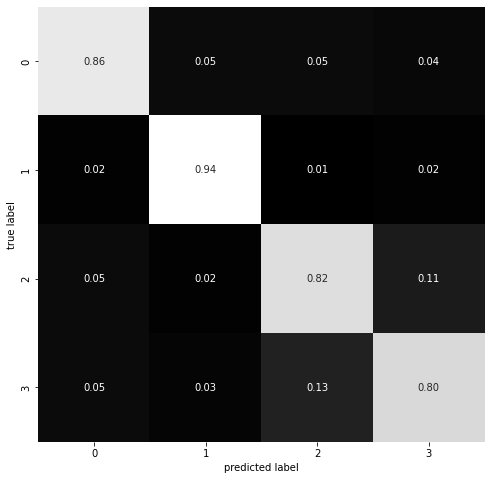

In [ ]:
conf_mx = confusion_matrix(test_labels, pred1)
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = np.round((conf_mx / row_sums), 2)

plot_confusion_matrix(norm_conf_mx)

### Visualize predictions

In [ ]:
preds = model.predict(test_dataset)
preds.shape

(7600, 4)

In [ ]:
cm = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)
df = pd.DataFrame(preds[0:15]
                  ,columns = ['World','Sports','Business','Sci/Tech']).T
df.style.format("{:.2%}").background_gradient(cmap=cm)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
World,0.03%,99.93%,0.08%,0.48%,99.84%,0.61%,0.36%,8.57%,95.17%,1.30%,99.85%,0.15%,1.08%,90.15%,99.91%
Sports,99.96%,0.00%,0.00%,99.44%,0.01%,0.04%,99.50%,89.99%,0.20%,0.03%,0.00%,0.45%,0.05%,4.46%,0.00%
Business,0.00%,0.06%,2.45%,0.04%,0.11%,23.87%,0.03%,0.17%,0.66%,92.15%,0.13%,0.64%,98.14%,1.30%,0.05%
Sci/Tech,0.01%,0.01%,97.47%,0.04%,0.04%,75.48%,0.11%,1.27%,3.98%,6.52%,0.01%,98.76%,0.73%,4.09%,0.04%


## Experiment C.1: Single Layer LSTM

### Create the model

In [ ]:
num_classes = 4
model = tf.keras.Sequential([encoder
                            ,tf.keras.layers.Embedding(input_dim=len(encoder.get_vocabulary())
                            ,output_dim=64
                            # Use masking to handle the variable sequence lengths
                            ,mask_zero=True)
                            ,tf.keras.layers.LSTM(64)
                            ,tf.keras.layers.Dense(64, activation='relu')
                            ,tf.keras.layers.Dense(num_classes, activation='softmax')
])

<div class="alert alert-block alert-success"> 
Please note that we choose to Keras sequential model here since all the layers in the model only have single input and produce single output. </div>

<div class="alert alert-block alert-info"> 
<b>tf.keras.Model</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/Model
</div>  

### Model Architecture Summary

In [ ]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (TextV  (None, None)             0         
 ectorization)                                                   
                                                                 
 embedding_6 (Embedding)     (None, None, 64)          64000     
                                                                 
 lstm (LSTM)                 (None, 64)                33024     
                                                                 
 dense_11 (Dense)            (None, 64)                4160      
                                                                 
 dense_12 (Dense)            (None, 4)                 260       
                                                                 
Total params: 101,444
Trainable params: 101,444
Non-trainable params: 0
________________________________________________

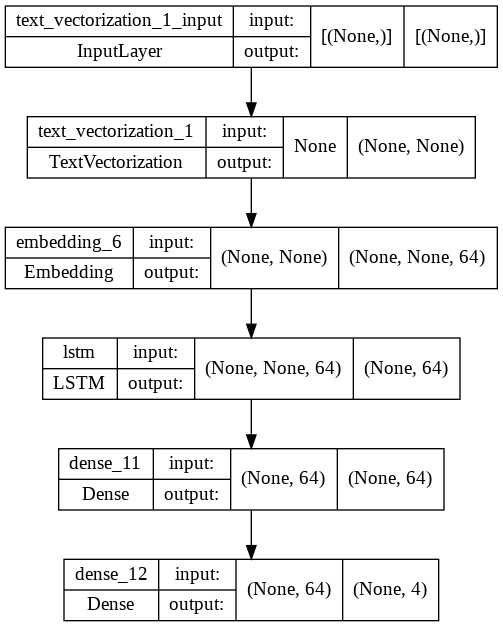

In [ ]:
keras.utils.plot_model(model, "SingleLayerLSTM.png", show_shapes=True)

### Compile Model 

<div class="alert alert-block alert-info">
<b>tf.keras.losses.SparseCategoricalCrossentropy</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy</div>

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4)
              ,loss=tf.keras.losses.SparseCategoricalCrossentropy()
              ,metrics=['accuracy'])

The embedding layer [uses masking](../../guide/keras/masking_and_padding) to handle the varying sequence-lengths. All the layers after the `Embedding` support masking:

In [ ]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


### Train the model

<div class="alert alert-block alert-success">
    <b>Module: tf.keras.callbacks</b></div>

<div class="alert alert-block alert-info">
<b>tf.keras.callbacks.EarlyStopping</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping</div>

<div class="alert alert-block alert-info">
<b>tf.keras.callbacks.ModelCheckpoint</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint</div>

In [ ]:
start = time.time()
history = model.fit(train_dataset
                    ,epochs = 150
                    ,validation_data=validation_dataset
                    ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)]
                    )
print("Total time: ", time.time() - start, "seconds")

Epoch 1/150
1782/1782 [==============================] - 30s 13ms/step - loss: 0.8596 - accuracy: 0.6265 - val_loss: 0.5959 - val_accuracy: 0.7855
Epoch 2/150
1782/1782 [==============================] - 21s 12ms/step - loss: 0.5026 - accuracy: 0.8204 - val_loss: 0.4690 - val_accuracy: 0.8385
Epoch 3/150
1782/1782 [==============================] - 22s 12ms/step - loss: 0.4534 - accuracy: 0.8367 - val_loss: 0.4523 - val_accuracy: 0.8405
Epoch 4/150
1782/1782 [==============================] - 21s 12ms/step - loss: 0.4412 - accuracy: 0.8408 - val_loss: 0.4468 - val_accuracy: 0.8380
Epoch 5/150
1782/1782 [==============================] - 22s 12ms/step - loss: 0.4322 - accuracy: 0.8447 - val_loss: 0.4343 - val_accuracy: 0.8453
Epoch 6/150
1782/1782 [==============================] - 21s 12ms/step - loss: 0.4210 - accuracy: 0.8486 - val_loss: 0.4204 - val_accuracy: 0.8533
Epoch 7/150
1782/1782 [==============================] - 22s 12ms/step - loss: 0.4069 - accuracy: 0.8544 - val_loss: 0

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

119/119 [==============================] - 1s 6ms/step - loss: 0.3961 - accuracy: 0.8549
Test Loss: 0.396110475063324
Test Accuracy: 0.8548684120178223


### Plotting Performance Metrics

Use Matplotlib to create 2 plots--displaying the training and validation loss (resp. accuracy) for each (training) epoch side by side.

In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
losses = history.history['loss']
accs = history.history['accuracy']
val_losses = history.history['val_loss']
val_accs = history.history['val_accuracy']
epochs = len(losses)

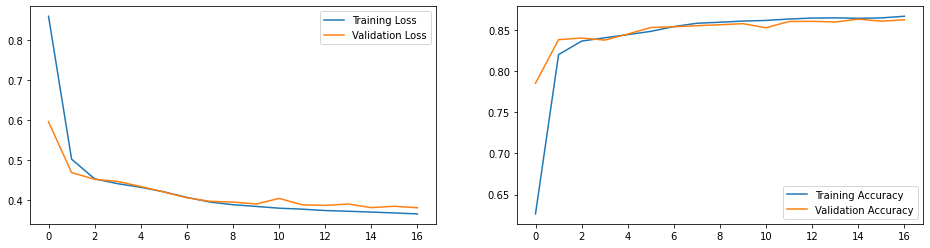

In [ ]:
plt.figure(figsize=(16, 4))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

### Confusion Matrix

In [ ]:
pred1 = model.predict(test_dataset)
pred1 = np.argmax(pred1, axis=1)

test_labels = np.concatenate([label for example, label in test_dataset], axis=0)
test_labels

array([1, 0, 3, ..., 3, 2, 1])

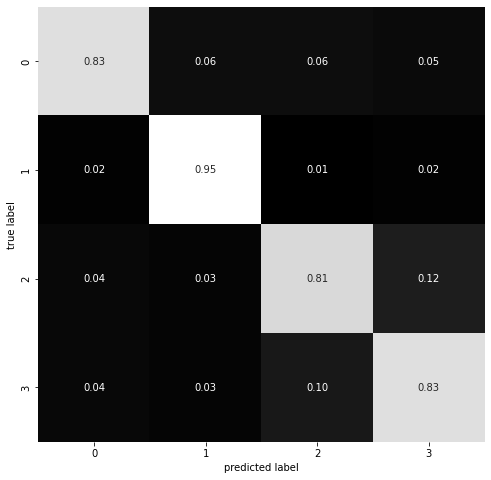

In [ ]:
conf_mx = confusion_matrix(test_labels, pred1)
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = np.round((conf_mx / row_sums), 2)

plot_confusion_matrix(norm_conf_mx)

### Visualize predictions

In [ ]:
preds = model.predict(test_dataset)
preds.shape

(7600, 4)

In [ ]:
cm = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)
df = pd.DataFrame(preds[0:15]
                  ,columns = ['World','Sports','Business','Sci/Tech']).T
df.style.format("{:.2%}").background_gradient(cmap=cm)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
World,0.37%,99.87%,0.11%,1.36%,99.60%,0.61%,0.84%,15.49%,89.78%,1.97%,99.87%,0.28%,0.59%,91.15%,99.36%
Sports,99.59%,0.02%,0.01%,98.47%,0.07%,0.17%,98.77%,83.27%,0.82%,0.06%,0.02%,0.64%,0.03%,0.87%,0.01%
Business,0.02%,0.08%,4.33%,0.08%,0.19%,12.49%,0.08%,0.09%,1.58%,78.92%,0.09%,1.41%,98.36%,1.40%,0.46%
Sci/Tech,0.02%,0.03%,95.54%,0.09%,0.14%,86.74%,0.30%,1.15%,7.83%,19.04%,0.03%,97.67%,1.02%,6.59%,0.16%


## Experiment C.2: Single Layer Bidirectional LSTM

### Create the model

In [ ]:
num_classes = 4
model = tf.keras.Sequential([encoder
                            ,tf.keras.layers.Embedding(input_dim=len(encoder.get_vocabulary())
                            ,output_dim=64
                            # Use masking to handle the variable sequence lengths
                            ,mask_zero=True)
                            ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64))
                            ,tf.keras.layers.Dense(64, activation='relu')
                            ,tf.keras.layers.Dense(num_classes, activation='softmax')
])

<div class="alert alert-block alert-success"> 
Please note that we choose to Keras sequential model here since all the layers in the model only have single input and produce single output. </div>

<div class="alert alert-block alert-info"> 
<b>tf.keras.Model</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/Model
</div>  

### Model Architecture Summary

In [ ]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (TextV  (None, None)             0         
 ectorization)                                                   
                                                                 
 embedding_11 (Embedding)    (None, None, 64)          64000     
                                                                 
 bidirectional_2 (Bidirectio  (None, 128)              66048     
 nal)                                                            
                                                                 
 dense_21 (Dense)            (None, 64)                8256      
                                                                 
 dense_22 (Dense)            (None, 4)                 260       
                                                                 
Total params: 138,564
Trainable params: 138,564
Non-t

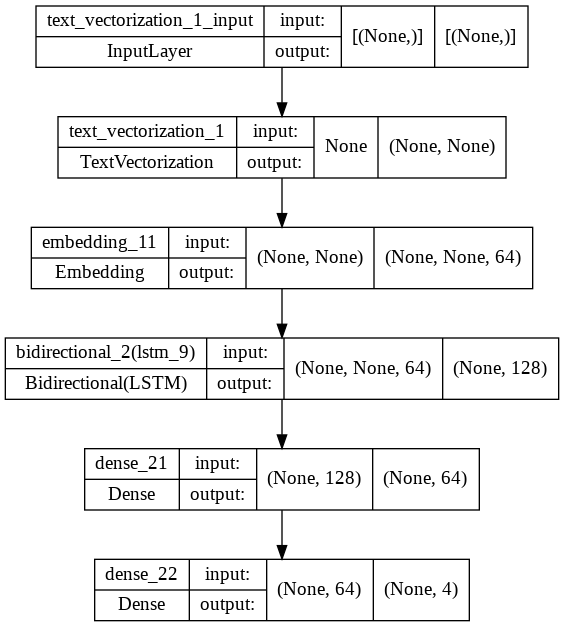

In [ ]:
keras.utils.plot_model(model, "SingleLayerBidirectionalLSTM.png", show_shapes=True)

### Compile Model 

<div class="alert alert-block alert-info">
<b>tf.keras.losses.SparseCategoricalCrossentropy</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy</div>

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4)
              ,loss=tf.keras.losses.SparseCategoricalCrossentropy()
              ,metrics=['accuracy'])

The embedding layer [uses masking](../../guide/keras/masking_and_padding) to handle the varying sequence-lengths. All the layers after the `Embedding` support masking:

In [ ]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


### Train the model

<div class="alert alert-block alert-success">
    <b>Module: tf.keras.callbacks</b></div>

<div class="alert alert-block alert-info">
<b>tf.keras.callbacks.EarlyStopping</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping</div>

<div class="alert alert-block alert-info">
<b>tf.keras.callbacks.ModelCheckpoint</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint</div>

In [ ]:
start = time.time()
history = model.fit(train_dataset
                    ,epochs = 150
                    ,validation_data=validation_dataset
                    ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)]
                    )
print("Total time: ", time.time() - start, "seconds")

Epoch 1/150
1782/1782 [==============================] - 46s 20ms/step - loss: 0.6908 - accuracy: 0.7431 - val_loss: 0.4765 - val_accuracy: 0.8388
Epoch 2/150
1782/1782 [==============================] - 33s 18ms/step - loss: 0.4609 - accuracy: 0.8358 - val_loss: 0.4546 - val_accuracy: 0.8387
Epoch 3/150
1782/1782 [==============================] - 32s 18ms/step - loss: 0.4334 - accuracy: 0.8443 - val_loss: 0.4289 - val_accuracy: 0.8517
Epoch 4/150
1782/1782 [==============================] - 32s 18ms/step - loss: 0.4143 - accuracy: 0.8509 - val_loss: 0.4078 - val_accuracy: 0.8580
Epoch 5/150
1782/1782 [==============================] - 32s 18ms/step - loss: 0.4002 - accuracy: 0.8549 - val_loss: 0.3993 - val_accuracy: 0.8588
Epoch 6/150
1782/1782 [==============================] - 32s 18ms/step - loss: 0.3907 - accuracy: 0.8582 - val_loss: 0.3980 - val_accuracy: 0.8578
Epoch 7/150
1782/1782 [==============================] - 32s 18ms/step - loss: 0.3837 - accuracy: 0.8601 - val_loss: 0

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

119/119 [==============================] - 1s 8ms/step - loss: 0.3992 - accuracy: 0.8529
Test Loss: 0.39922112226486206
Test Accuracy: 0.8528947234153748


### Plotting Performance Metrics

Use Matplotlib to create 2 plots--displaying the training and validation loss (resp. accuracy) for each (training) epoch side by side.

In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
losses = history.history['loss']
accs = history.history['accuracy']
val_losses = history.history['val_loss']
val_accs = history.history['val_accuracy']
epochs = len(losses)

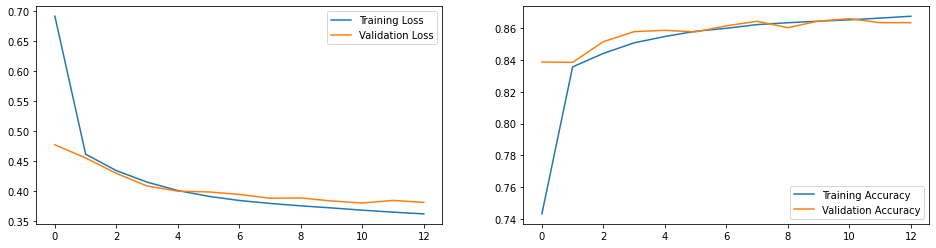

In [ ]:
plt.figure(figsize=(16, 4))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

### Confusion Matrix

In [ ]:
pred1 = model.predict(test_dataset)
pred1 = np.argmax(pred1, axis=1)

test_labels = np.concatenate([label for example, label in test_dataset], axis=0)
test_labels

array([1, 0, 3, ..., 3, 2, 1])

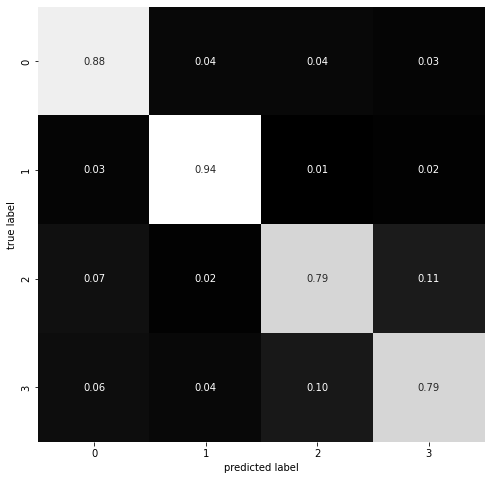

In [ ]:
conf_mx = confusion_matrix(test_labels, pred1)
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = np.round((conf_mx / row_sums), 2)

plot_confusion_matrix(norm_conf_mx)

### Visualize predictions

In [ ]:
preds = model.predict(test_dataset)
preds.shape

(7600, 4)

In [ ]:
cm = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)
df = pd.DataFrame(preds[0:15]
                  ,columns = ['World','Sports','Business','Sci/Tech']).T
df.style.format("{:.2%}").background_gradient(cmap=cm)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
World,0.05%,99.96%,0.41%,0.62%,99.84%,0.54%,0.71%,19.92%,96.05%,3.55%,99.98%,0.40%,0.99%,94.47%,99.81%
Sports,99.82%,0.01%,0.00%,99.21%,0.01%,0.10%,98.97%,77.96%,0.20%,0.02%,0.00%,1.42%,0.01%,0.82%,0.00%
Business,0.10%,0.01%,6.05%,0.08%,0.05%,16.59%,0.08%,0.19%,0.45%,74.34%,0.01%,0.48%,98.36%,0.97%,0.10%
Sci/Tech,0.02%,0.01%,93.54%,0.09%,0.10%,82.77%,0.24%,1.93%,3.30%,22.09%,0.01%,97.69%,0.65%,3.74%,0.08%


## Experiment C.3: Multi-Layer Bidirectional LSTM

Keras recurrent layers have two available modes that are controlled by the `return_sequences` constructor argument:

* If `False` it returns only the last output for each input sequence (a 2D tensor of shape (batch_size, output_features)). This is the default, used in the previous model.

* If `True` the full sequences of successive outputs for each timestep is returned (a 3D tensor of shape `(batch_size, timesteps, output_features)`).

The interesting thing about using an `RNN` with `return_sequences=True` is that the output still has 3-axes, like the input, so it can be passed to another RNN layer, like this:

<img src="https://github.com/djp840/MSDS_458_Public/blob/master/images/multilayerBidirectionalLSTM.png?raw=1">

### Create the model

In [ ]:
num_classes = 4
model = tf.keras.Sequential([encoder
                            ,tf.keras.layers.Embedding(input_dim=len(encoder.get_vocabulary())
                            ,output_dim=64
                            ,mask_zero=True)
                            ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128,  return_sequences=True))
                            ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True))
                            ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32))
                            ,tf.keras.layers.Dense(64, activation='relu')
                            ,tf.keras.layers.Dropout(0.5)
                            ,tf.keras.layers.Dense(num_classes, activation='softmax')
])

<div class="alert alert-block alert-success"> 
Please note that we choose to Keras sequential model here since all the layers in the model only have single input and produce single output. </div>

<div class="alert alert-block alert-info"> 
<b>tf.keras.Model</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/Model
</div>  

### Model Architecture Summary

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding_1 (Embedding)     (None, None, 64)          64000     
                                                                 
 bidirectional_2 (Bidirectio  (None, None, 256)        197632    
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, None, 128)        164352    
 nal)                                                            
                                                                 
 bidirectional_4 (Bidirectio  (None, 64)               41216     
 nal)                                                 

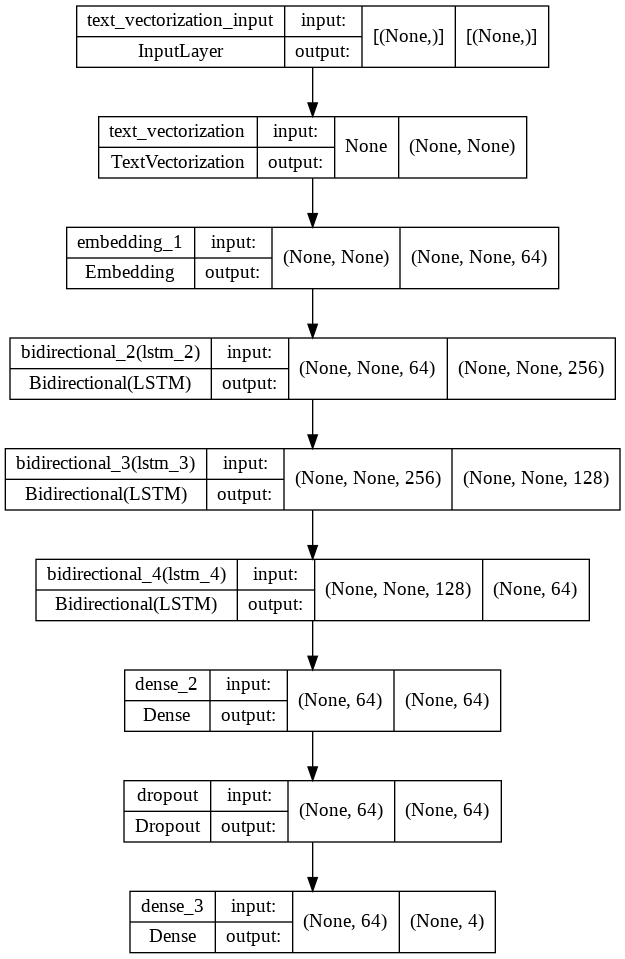

In [ ]:
keras.utils.plot_model(model, "MultiLayerBidirectionalLSTM.png", show_shapes=True)

### Compile Model 

<div class="alert alert-block alert-info">
<b>tf.keras.losses.SparseCategoricalCrossentropy</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy</div>

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4)
              ,loss=tf.keras.losses.SparseCategoricalCrossentropy()
              ,metrics=['accuracy'])

The embedding layer [uses masking](../../guide/keras/masking_and_padding) to handle the varying sequence-lengths. All the layers after the `Embedding` support masking:

In [ ]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True, True, True, True]


### Train the model

<div class="alert alert-block alert-success">
    <b>Module: tf.keras.callbacks</b></div>

<div class="alert alert-block alert-info">
<b>tf.keras.callbacks.EarlyStopping</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping</div>

<div class="alert alert-block alert-info">
<b>tf.keras.callbacks.ModelCheckpoint</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint</div>

In [ ]:
start = time.time()
history = model.fit(train_dataset
                    ,epochs = 150
                    ,validation_data=validation_dataset
                    ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)]
                    )
print("Total time: ", time.time() - start, "seconds")

Epoch 1/150
1782/1782 [==============================] - 88s 38ms/step - loss: 0.7141 - accuracy: 0.7124 - val_loss: 0.4676 - val_accuracy: 0.8387
Epoch 2/150
1782/1782 [==============================] - 60s 34ms/step - loss: 0.4834 - accuracy: 0.8333 - val_loss: 0.4472 - val_accuracy: 0.8430
Epoch 3/150
1782/1782 [==============================] - 60s 34ms/step - loss: 0.4624 - accuracy: 0.8395 - val_loss: 0.4338 - val_accuracy: 0.8482
Epoch 4/150
1782/1782 [==============================] - 60s 34ms/step - loss: 0.4502 - accuracy: 0.8431 - val_loss: 0.4369 - val_accuracy: 0.8455
Epoch 5/150
1782/1782 [==============================] - 60s 34ms/step - loss: 0.4342 - accuracy: 0.8493 - val_loss: 0.4153 - val_accuracy: 0.8563
Epoch 6/150
1782/1782 [==============================] - 60s 34ms/step - loss: 0.4172 - accuracy: 0.8551 - val_loss: 0.3961 - val_accuracy: 0.8580
Epoch 7/150
1782/1782 [==============================] - 60s 34ms/step - loss: 0.4076 - accuracy: 0.8594 - val_loss: 0

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

119/119 [==============================] - 2s 13ms/step - loss: 0.4048 - accuracy: 0.8524
Test Loss: 0.4047606885433197
Test Accuracy: 0.8523684144020081


### Plotting Performance Metrics

Use Matplotlib to create 2 plots--displaying the training and validation loss (resp. accuracy) for each (training) epoch side by side.

In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
losses = history.history['loss']
accs = history.history['accuracy']
val_losses = history.history['val_loss']
val_accs = history.history['val_accuracy']
epochs = len(losses)

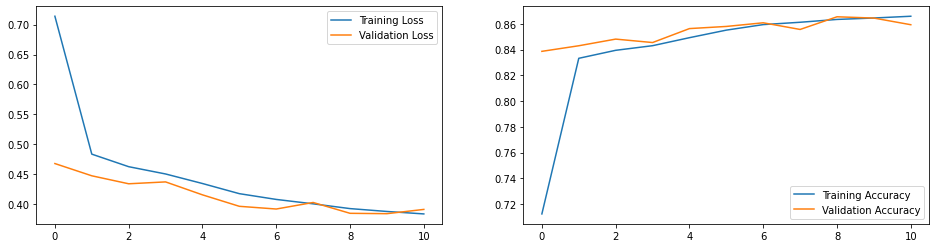

In [ ]:
plt.figure(figsize=(16, 4))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

### Confusion Matrix

In [ ]:
pred1 = model.predict(test_dataset)
pred1 = np.argmax(pred1, axis=1)

test_labels = np.concatenate([label for example, label in test_dataset], axis=0)
test_labels

array([1, 0, 3, ..., 3, 2, 1])

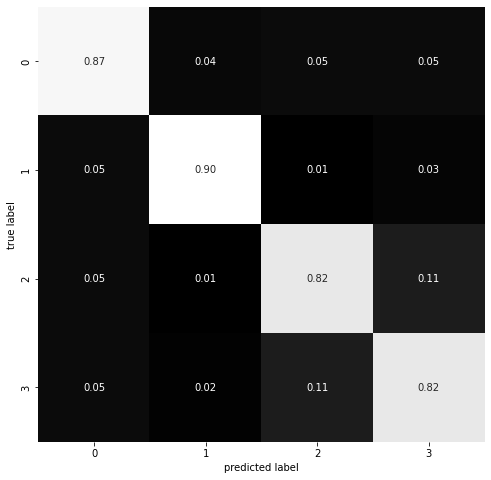

In [ ]:
conf_mx = confusion_matrix(test_labels, pred1)
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = np.round((conf_mx / row_sums), 2)

plot_confusion_matrix(norm_conf_mx)

### Visualize predictions

In [ ]:
preds = model.predict(test_dataset)
preds.shape

(7600, 4)

In [ ]:
cm = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)
df = pd.DataFrame(preds[0:15]
                  ,columns = ['World','Sports','Business','Sci/Tech']).T
df.style.format("{:.2%}").background_gradient(cmap=cm)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
World,0.24%,99.95%,0.18%,0.84%,99.87%,0.80%,0.69%,19.50%,91.85%,0.86%,99.97%,0.69%,0.42%,89.52%,99.93%
Sports,99.70%,0.00%,0.01%,99.03%,0.01%,0.08%,99.06%,76.70%,0.25%,0.03%,0.00%,0.19%,0.00%,0.83%,0.00%
Business,0.02%,0.02%,7.82%,0.04%,0.07%,10.21%,0.07%,0.62%,1.34%,84.53%,0.01%,1.89%,99.15%,1.98%,0.03%
Sci/Tech,0.05%,0.03%,91.99%,0.09%,0.06%,88.91%,0.18%,3.18%,6.56%,14.58%,0.01%,97.23%,0.43%,7.67%,0.04%


## Experiment C.4: Multi-Layer Bidirectional LSTM with increased model complexity

### Create the model

In [ ]:
num_classes = 4
model = tf.keras.Sequential([encoder
                            ,tf.keras.layers.Embedding(input_dim=len(encoder.get_vocabulary())
                            ,output_dim=64
                            ,mask_zero=True)
                            ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256,  return_sequences=True))
                            ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128,  return_sequences=True))
                            ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64))
                            ,tf.keras.layers.Dense(82, activation='relu')
                            ,tf.keras.layers.Dropout(0.5)
                            ,tf.keras.layers.Dense(num_classes, activation='softmax')
])

<div class="alert alert-block alert-success"> 
Please note that we choose to Keras sequential model here since all the layers in the model only have single input and produce single output. </div>

<div class="alert alert-block alert-info"> 
<b>tf.keras.Model</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/Model
</div>  

### Model Architecture Summary

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding_2 (Embedding)     (None, None, 64)          64000     
                                                                 
 bidirectional_5 (Bidirectio  (None, None, 512)        657408    
 nal)                                                            
                                                                 
 bidirectional_6 (Bidirectio  (None, None, 256)        656384    
 nal)                                                            
                                                                 
 bidirectional_7 (Bidirectio  (None, 128)              164352    
 nal)                                                 

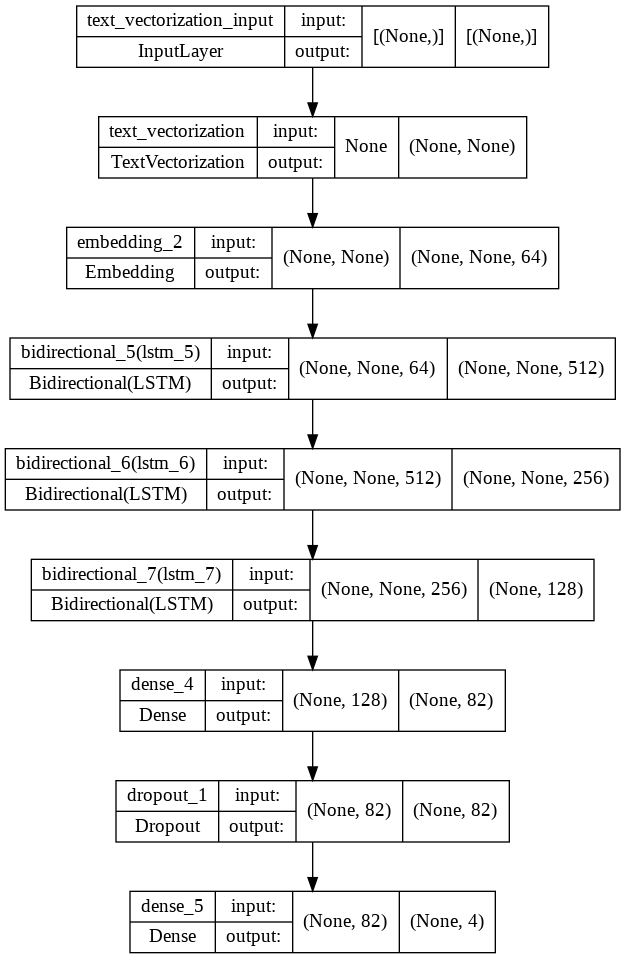

In [ ]:
keras.utils.plot_model(model, "MultiLayerBidirectionalLSTM_2.png", show_shapes=True)

### Compile Model 

<div class="alert alert-block alert-info">
<b>tf.keras.losses.SparseCategoricalCrossentropy</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy</div>

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4)
              ,loss=tf.keras.losses.SparseCategoricalCrossentropy()
              ,metrics=['accuracy'])

The embedding layer [uses masking](../../guide/keras/masking_and_padding) to handle the varying sequence-lengths. All the layers after the `Embedding` support masking:

In [ ]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True, True, True, True]


### Train the model

<div class="alert alert-block alert-success">
    <b>Module: tf.keras.callbacks</b></div>

<div class="alert alert-block alert-info">
<b>tf.keras.callbacks.EarlyStopping</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping</div>

<div class="alert alert-block alert-info">
<b>tf.keras.callbacks.ModelCheckpoint</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint</div>

In [ ]:
start = time.time()
history = model.fit(train_dataset
                    ,epochs = 150
                    ,validation_data=validation_dataset
                    ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)]
                    )
print("Total time: ", time.time() - start, "seconds")

Epoch 1/150
1782/1782 [==============================] - 99s 43ms/step - loss: 0.6491 - accuracy: 0.7504 - val_loss: 0.4459 - val_accuracy: 0.8443
Epoch 2/150
1782/1782 [==============================] - 70s 39ms/step - loss: 0.4590 - accuracy: 0.8390 - val_loss: 0.4151 - val_accuracy: 0.8540
Epoch 3/150
1782/1782 [==============================] - 70s 39ms/step - loss: 0.4300 - accuracy: 0.8494 - val_loss: 0.4057 - val_accuracy: 0.8550
Epoch 4/150
1782/1782 [==============================] - 70s 39ms/step - loss: 0.4139 - accuracy: 0.8542 - val_loss: 0.3954 - val_accuracy: 0.8632
Epoch 5/150
1782/1782 [==============================] - 70s 39ms/step - loss: 0.4030 - accuracy: 0.8577 - val_loss: 0.3954 - val_accuracy: 0.8598
Epoch 6/150
1782/1782 [==============================] - 70s 39ms/step - loss: 0.3953 - accuracy: 0.8599 - val_loss: 0.3858 - val_accuracy: 0.8652
Epoch 7/150
1782/1782 [==============================] - 70s 39ms/step - loss: 0.3906 - accuracy: 0.8612 - val_loss: 0

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

119/119 [==============================] - 2s 17ms/step - loss: 0.3950 - accuracy: 0.8561
Test Loss: 0.39499765634536743
Test Accuracy: 0.8560526371002197


### Plotting Performance Metrics

Use Matplotlib to create 2 plots--displaying the training and validation loss (resp. accuracy) for each (training) epoch side by side.

In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
losses = history.history['loss']
accs = history.history['accuracy']
val_losses = history.history['val_loss']
val_accs = history.history['val_accuracy']
epochs = len(losses)

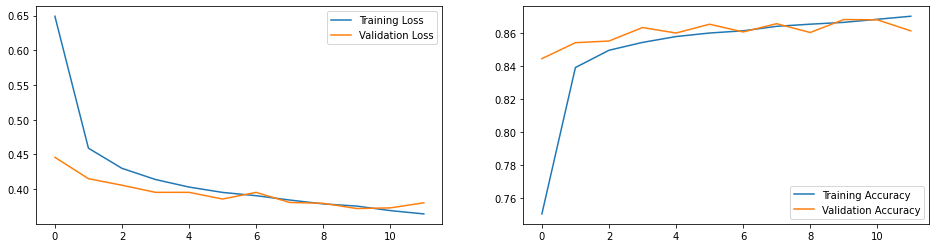

In [ ]:
plt.figure(figsize=(16, 4))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

### Confusion Matrix

In [ ]:
pred1 = model.predict(test_dataset)
pred1 = np.argmax(pred1, axis=1)

test_labels = np.concatenate([label for example, label in test_dataset], axis=0)
test_labels

array([1, 0, 3, ..., 3, 2, 1])

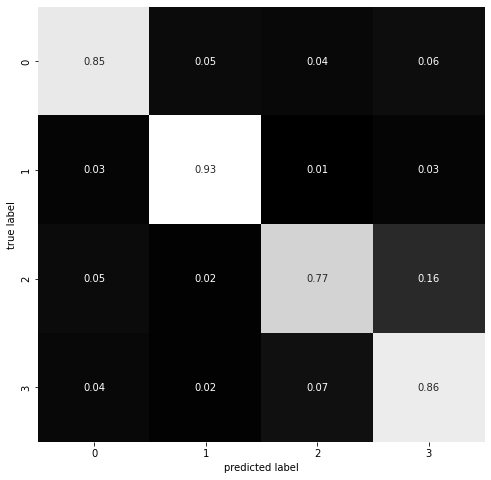

In [ ]:
conf_mx = confusion_matrix(test_labels, pred1)
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = np.round((conf_mx / row_sums), 2)

plot_confusion_matrix(norm_conf_mx)

### Visualize predictions

In [ ]:
preds = model.predict(test_dataset)
preds.shape

(7600, 4)

In [ ]:
cm = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)
df = pd.DataFrame(preds[0:15]
                  ,columns = ['World','Sports','Business','Sci/Tech']).T
df.style.format("{:.2%}").background_gradient(cmap=cm)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
World,0.07%,99.97%,0.05%,0.25%,99.81%,0.17%,0.41%,3.09%,89.25%,0.80%,99.97%,0.08%,0.37%,93.50%,99.74%
Sports,99.90%,0.00%,0.00%,99.71%,0.03%,0.03%,99.37%,96.16%,0.33%,0.06%,0.00%,0.04%,0.00%,1.69%,0.03%
Business,0.01%,0.01%,4.02%,0.01%,0.09%,4.04%,0.05%,0.10%,0.64%,81.19%,0.01%,0.87%,99.21%,0.99%,0.13%
Sci/Tech,0.02%,0.01%,95.93%,0.02%,0.07%,95.77%,0.17%,0.65%,9.78%,17.95%,0.01%,99.01%,0.43%,3.82%,0.10%


## Experiment C.5: Single Layer LSTM with vocabulary size of 2000

### Create the Text Encoder

In [ ]:
VOCAB_SIZE=2000
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [ ]:
vocab = np.array(encoder.get_vocabulary())
len(vocab)

2000

Here are the first 20 tokens. After the padding and unknown tokens they're sorted by frequency: 

In [ ]:
vocab[:20]

array(['', '[UNK]', 'the', 'a', 'to', 'of', 'in', 'and', 'on', 'for',
       'that', '39s', 'with', 'its', 'as', 'at', 'is', 'said', 'by', 'it'],
      dtype='<U19')

Here are the 20 least frequent words.

In [ ]:
vocab[-20:]

array(['cabinet', 'spend', 'situation', 'rallied', 'person', 'journal',
       'enron', 'defeated', 'allowing', 'wins', 'tiny', 'seasons', 'kill',
       'indiana', 'edged', 'ebay', 'chinas', 'cards', 'brian', 'tight'],
      dtype='<U19')

### Create the model

In [ ]:
num_classes = 4
model = tf.keras.Sequential([encoder
                            ,tf.keras.layers.Embedding(input_dim=len(encoder.get_vocabulary())
                            ,output_dim=64
                            # Use masking to handle the variable sequence lengths
                            ,mask_zero=True)
                            ,tf.keras.layers.LSTM(64)
                            ,tf.keras.layers.Dense(64, activation='relu')
                            ,tf.keras.layers.Dropout(0.5)
                            ,tf.keras.layers.Dense(num_classes, activation='softmax')
])

<div class="alert alert-block alert-success"> 
Please note that we choose to Keras sequential model here since all the layers in the model only have single input and produce single output. </div>

<div class="alert alert-block alert-info"> 
<b>tf.keras.Model</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/Model
</div>  

### Model Architecture Summary

In [ ]:
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_3 (TextV  (None, None)             0         
 ectorization)                                                   
                                                                 
 embedding_15 (Embedding)    (None, None, 64)          128000    
                                                                 
 lstm_9 (LSTM)               (None, 64)                33024     
                                                                 
 dense_25 (Dense)            (None, 64)                4160      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_26 (Dense)            (None, 4)                 260       
                                                     

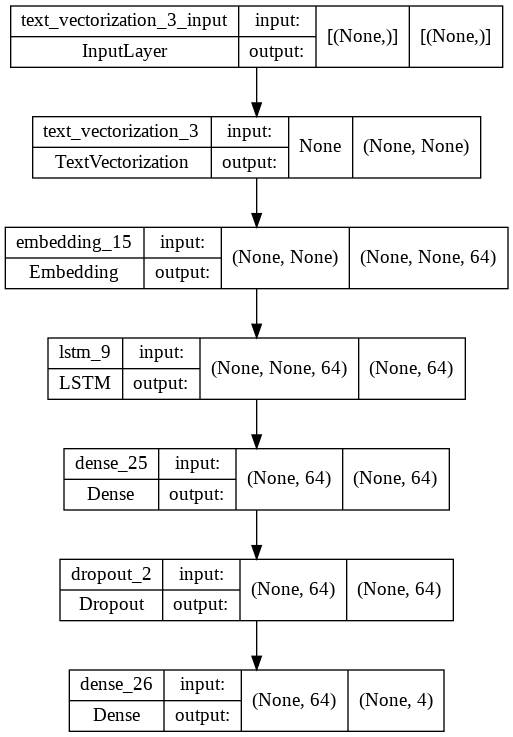

In [ ]:
keras.utils.plot_model(model, "SingleLayerLSTM_Vocab2000.png", show_shapes=True)

### Compile Model 

<div class="alert alert-block alert-info">
<b>tf.keras.losses.SparseCategoricalCrossentropy</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy</div>

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4)
              ,loss=tf.keras.losses.SparseCategoricalCrossentropy()
              ,metrics=['accuracy'])

The embedding layer [uses masking](../../guide/keras/masking_and_padding) to handle the varying sequence-lengths. All the layers after the `Embedding` support masking:

In [ ]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True, True]


### Train the model

<div class="alert alert-block alert-success">
    <b>Module: tf.keras.callbacks</b></div>

<div class="alert alert-block alert-info">
<b>tf.keras.callbacks.EarlyStopping</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping</div>

<div class="alert alert-block alert-info">
<b>tf.keras.callbacks.ModelCheckpoint</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint</div>

In [ ]:
start = time.time()
history = model.fit(train_dataset
                    ,epochs = 150
                    ,validation_data=validation_dataset
                    ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)]
                    )
print("Total time: ", time.time() - start, "seconds")

Epoch 1/150
1782/1782 [==============================] - 89s 48ms/step - loss: 0.7660 - accuracy: 0.7135 - val_loss: 0.4609 - val_accuracy: 0.8510
Epoch 2/150
1782/1782 [==============================] - 16s 9ms/step - loss: 0.4423 - accuracy: 0.8582 - val_loss: 0.3827 - val_accuracy: 0.8707
Epoch 3/150
1782/1782 [==============================] - 17s 9ms/step - loss: 0.3847 - accuracy: 0.8735 - val_loss: 0.3613 - val_accuracy: 0.8733
Epoch 4/150
1782/1782 [==============================] - 17s 9ms/step - loss: 0.3624 - accuracy: 0.8799 - val_loss: 0.3530 - val_accuracy: 0.8740
Epoch 5/150
1782/1782 [==============================] - 16s 9ms/step - loss: 0.3499 - accuracy: 0.8835 - val_loss: 0.3518 - val_accuracy: 0.8783
Epoch 6/150
1782/1782 [==============================] - 16s 9ms/step - loss: 0.3403 - accuracy: 0.8856 - val_loss: 0.3495 - val_accuracy: 0.8793
Epoch 7/150
1782/1782 [==============================] - 16s 9ms/step - loss: 0.3361 - accuracy: 0.8870 - val_loss: 0.3435 

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

119/119 [==============================] - 1s 5ms/step - loss: 0.3543 - accuracy: 0.8761
Test Loss: 0.3542609214782715
Test Accuracy: 0.8760526180267334


### Plotting Performance Metrics

Use Matplotlib to create 2 plots--displaying the training and validation loss (resp. accuracy) for each (training) epoch side by side.

In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
losses = history.history['loss']
accs = history.history['accuracy']
val_losses = history.history['val_loss']
val_accs = history.history['val_accuracy']
epochs = len(losses)

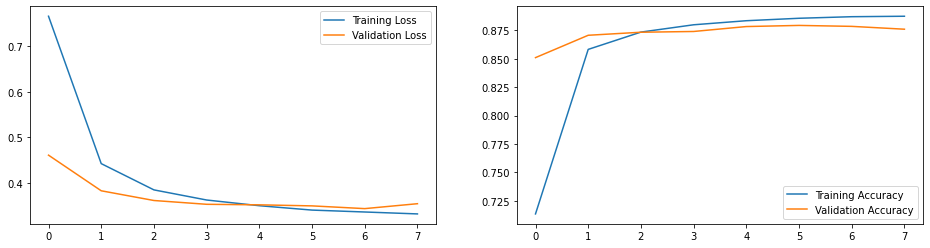

In [ ]:
plt.figure(figsize=(16, 4))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

### Confusion Matrix

In [ ]:
pred1 = model.predict(test_dataset)
pred1 = np.argmax(pred1, axis=1)

test_labels = np.concatenate([label for example, label in test_dataset], axis=0)
test_labels

array([1, 0, 3, ..., 3, 2, 1])

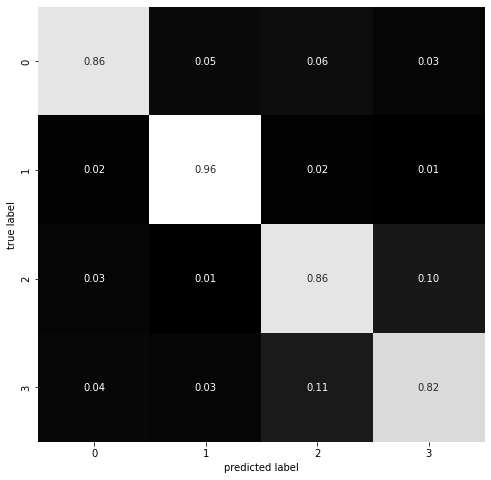

In [ ]:
conf_mx = confusion_matrix(test_labels, pred1)
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = np.round((conf_mx / row_sums), 2)

plot_confusion_matrix(norm_conf_mx)

### Visualize predictions

In [ ]:
preds = model.predict(test_dataset)
preds.shape

(7600, 4)

In [ ]:
cm = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)
df = pd.DataFrame(preds[0:15]
                  ,columns = ['World','Sports','Business','Sci/Tech']).T
df.style.format("{:.2%}").background_gradient(cmap=cm)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
World,0.11%,99.97%,0.09%,0.89%,99.93%,0.26%,0.89%,5.38%,95.32%,0.74%,99.98%,0.78%,0.87%,92.16%,99.91%
Sports,99.85%,0.00%,0.01%,98.91%,0.00%,0.04%,98.83%,93.87%,0.62%,0.00%,0.00%,0.46%,0.01%,1.97%,0.00%
Business,0.02%,0.02%,4.35%,0.13%,0.03%,6.12%,0.09%,0.09%,1.60%,98.47%,0.01%,1.07%,98.48%,1.47%,0.02%
Sci/Tech,0.02%,0.01%,95.56%,0.07%,0.04%,93.58%,0.19%,0.66%,2.45%,0.79%,0.00%,97.70%,0.64%,4.40%,0.07%


## Experiment D.1: 1-D CNN 

### Create the Text Encoder

In [ ]:
VOCAB_SIZE=1000
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

### Create the model

In [ ]:
num_classes = 4
model = tf.keras.Sequential([encoder
                            ,tf.keras.layers.Embedding(input_dim=len(encoder.get_vocabulary())
                            ,output_dim=64, mask_zero=True)
                            ,tf.keras.layers.Conv1D(filters=64, kernel_size=6 ,activation='relu')
                            ,tf.keras.layers.Dense(32, activation='relu')
                            ,tf.keras.layers.Dropout(0.5)
                            ,tf.keras.layers.GlobalMaxPool1D()
                            ,tf.keras.layers.Dense(num_classes, activation='softmax')
])

### Model Architecture Summary

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (TextV  (None, None)             0         
 ectorization)                                                   
                                                                 
 embedding_2 (Embedding)     (None, None, 64)          64000     
                                                                 
 conv1d_2 (Conv1D)           (None, None, 64)          24640     
                                                                 
 dense_4 (Dense)             (None, None, 32)          2080      
                                                                 
 dropout_2 (Dropout)         (None, None, 32)          0         
                                                                 
 global_max_pooling1d_2 (Glo  (None, 32)               0         
 balMaxPooling1D)                                     

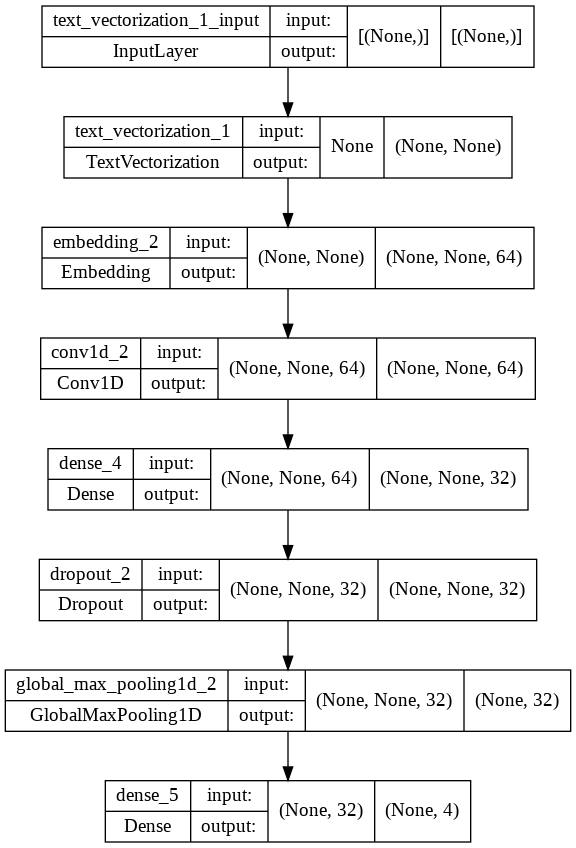

In [ ]:
keras.utils.plot_model(model, "1D_CNN.png", show_shapes=True)

### Compile Model 

<div class="alert alert-block alert-info">
<b>tf.keras.losses.SparseCategoricalCrossentropy</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy</div>

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4)
              ,loss=tf.keras.losses.SparseCategoricalCrossentropy() 
              ,metrics=['accuracy'])

The embedding layer [uses masking](../../guide/keras/masking_and_padding) to handle the varying sequence-lengths. All the layers after the `Embedding` support masking:

In [ ]:
print([layer.supports_masking for layer in model.layers])

[False, True, False, True, True, False, True]


### Train the model

<div class="alert alert-block alert-success">
    <b>Module: tf.keras.callbacks</b></div>

<div class="alert alert-block alert-info">
<b>tf.keras.callbacks.EarlyStopping</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping</div>

<div class="alert alert-block alert-info">
<b>tf.keras.callbacks.ModelCheckpoint</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint</div>

In [ ]:
start = time.time()
history = model.fit(train_dataset
                    ,epochs = 150
                    ,validation_data=validation_dataset
                    ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)]
                    )
print("Total time: ", time.time() - start, "seconds")

Epoch 1/150
1782/1782 [==============================] - 16s 8ms/step - loss: 0.9519 - accuracy: 0.6428 - val_loss: 0.6388 - val_accuracy: 0.8242
Epoch 2/150
1782/1782 [==============================] - 9s 5ms/step - loss: 0.4640 - accuracy: 0.8371 - val_loss: 0.5411 - val_accuracy: 0.8498
Epoch 3/150
1782/1782 [==============================] - 9s 5ms/step - loss: 0.4315 - accuracy: 0.8468 - val_loss: 0.5231 - val_accuracy: 0.8513
Epoch 4/150
1782/1782 [==============================] - 9s 5ms/step - loss: 0.4200 - accuracy: 0.8501 - val_loss: 0.5173 - val_accuracy: 0.8495
Epoch 5/150
1782/1782 [==============================] - 9s 5ms/step - loss: 0.4105 - accuracy: 0.8534 - val_loss: 0.5039 - val_accuracy: 0.8533
Epoch 6/150
1782/1782 [==============================] - 9s 5ms/step - loss: 0.4061 - accuracy: 0.8549 - val_loss: 0.4993 - val_accuracy: 0.8535
Epoch 7/150
1782/1782 [==============================] - 9s 5ms/step - loss: 0.4020 - accuracy: 0.8561 - val_loss: 0.5037 - val_a

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

119/119 [==============================] - 0s 4ms/step - loss: 0.4944 - accuracy: 0.8486
Test Loss: 0.4943552613258362
Test Accuracy: 0.8485526442527771


### Plotting Performance Metrics

Use Matplotlib to create 2 plots--displaying the training and validation loss (resp. accuracy) for each (training) epoch side by side.

In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
losses = history.history['loss']
accs = history.history['accuracy']
val_losses = history.history['val_loss']
val_accs = history.history['val_accuracy']
epochs = len(losses)

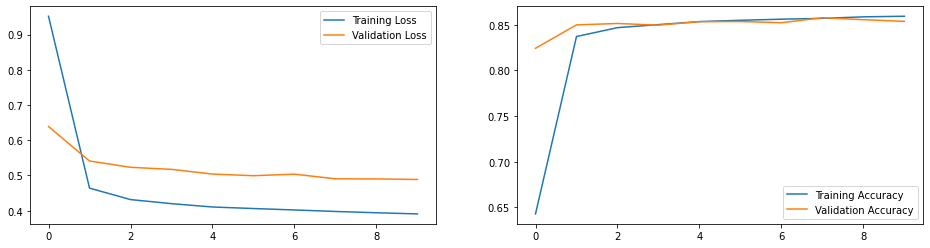

In [ ]:
plt.figure(figsize=(16, 4))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

### Confusion Matrix

In [ ]:
pred1 = model.predict(test_dataset)
pred1 = np.argmax(pred1, axis=1)

test_labels = np.concatenate([label for example, label in test_dataset], axis=0)
test_labels

array([1, 0, 3, ..., 3, 2, 1])

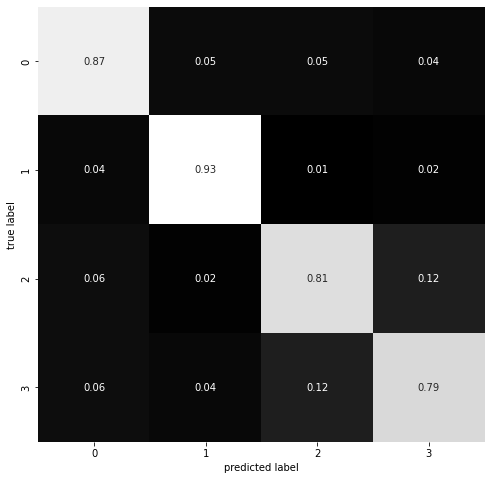

In [ ]:
conf_mx = confusion_matrix(test_labels, pred1)
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = np.round((conf_mx / row_sums), 2)

plot_confusion_matrix(norm_conf_mx)

### Visualize predictions

In [ ]:
preds = model.predict(test_dataset)
preds.shape

(7600, 4)

In [ ]:
cm = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)
df = pd.DataFrame(preds[0:15]
                  ,columns = ['World','Sports','Business','Sci/Tech']).T
df.style.format("{:.2%}").background_gradient(cmap=cm)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
World,1.64%,95.23%,1.69%,8.34%,92.71%,6.09%,4.51%,34.73%,63.41%,12.09%,98.68%,6.14%,10.67%,76.56%,91.54%
Sports,97.37%,0.38%,0.17%,86.53%,1.25%,1.84%,89.77%,55.09%,3.18%,1.85%,0.09%,8.72%,1.83%,2.84%,0.32%
Business,0.44%,3.21%,9.65%,2.61%,2.58%,32.58%,2.70%,0.97%,11.13%,60.40%,0.51%,5.30%,73.53%,11.97%,5.22%
Sci/Tech,0.56%,1.18%,88.48%,2.53%,3.46%,59.50%,3.02%,9.22%,22.28%,25.66%,0.72%,79.84%,13.97%,8.64%,2.91%
